# Energy Consumption (Time Series)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# Data Import + Processing

In [2]:
data = pd.read_csv("Energy Consumption Dataset.csv")
data['DATE'] = pd.to_datetime(data['DATE'],format='%d/%m/%Y')
date_range = pd.date_range(start=data['DATE'].min(), end=data['DATE'].max(), freq='MS')
data.set_index(date_range, inplace=True)
data.drop(['DATE'], axis=1, inplace=True)
data

,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
1990-01-01,18.0,725.1,548.8
1990-02-01,15.8,706.7,640.7
1990-03-01,17.3,624.5,511.1
1990-04-01,18.9,574.7,515.3
1990-05-01,22.0,553.2,488.4
...,...,...,...
2022-09-01,27.7,986.2,513.3
2022-10-01,31.8,936.1,373.1
2022-11-01,31.0,973.4,343.9
2022-12-01,32.4,1147.2,348.3


# Data Visualization

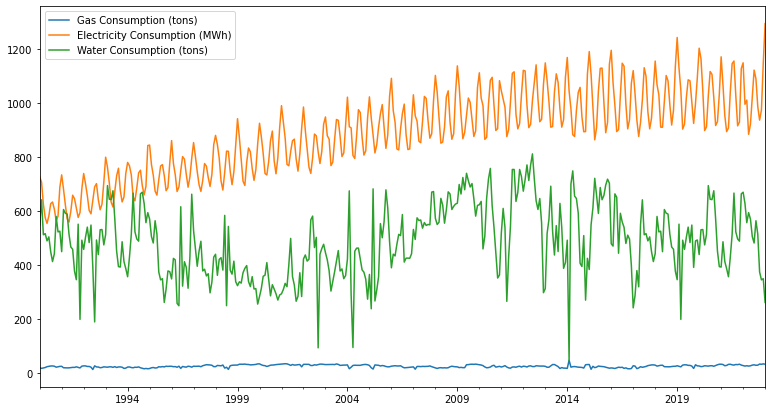

In [3]:
data.plot(figsize=(13,7))
plt.show()

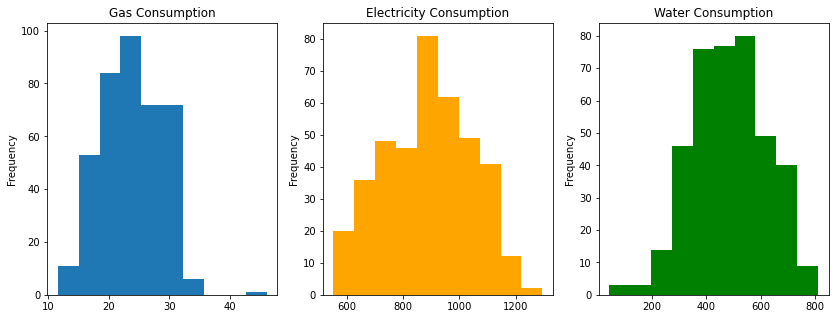

In [4]:
gas_consumption = data['Gas Consumption (tons)']
electricity_consumption = data['Electricity Consumption (MWh)']
water_consumption = data['Water Consumption (tons)']

fig, ax = plt.subplots(1, 3, figsize=(14, 5))
gas_consumption.plot(ax=ax[0], kind='hist')
electricity_consumption.plot(ax=ax[1], kind='hist',color='orange')
water_consumption.plot(ax=ax[2], kind='hist',color='green')
ax[0].set_title('Gas Consumption')
ax[1].set_title('Electricity Consumption')
ax[2].set_title('Water Consumption')
plt.show()

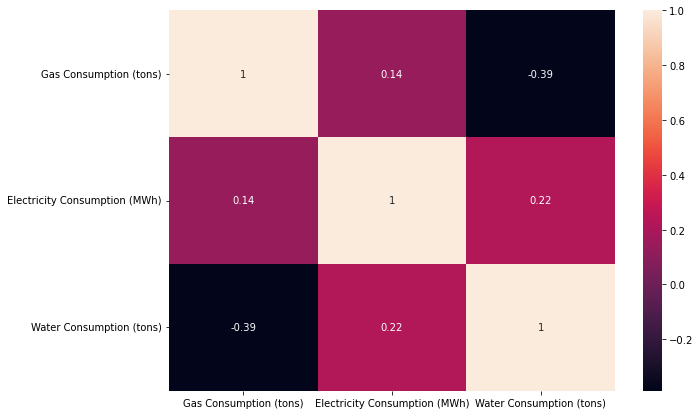

In [5]:
cor = data.corr()
plt.figure(figsize = (10,7))
sns.heatmap(cor,annot=True)
plt.show()

I plotted a correlation heatmap to check if the data is correlated. If so, then I may ot may not have to use the exog function but judging from the heatmap, the features are not correlated enough

In [6]:
gas_mean = gas_consumption.mean()
gas_median = gas_consumption.median()
gas_std = gas_consumption.std()
gas_min = gas_consumption.min()
gas_max = gas_consumption.max()

electricity_mean = electricity_consumption.mean()
electricity_median = electricity_consumption.median()
electricity_std = electricity_consumption.std()
electricity_min = electricity_consumption.min()
electricity_max = electricity_consumption.max()

water_mean = water_consumption.mean()
water_median = water_consumption.median()
water_std = water_consumption.std()
water_min = water_consumption.min()
water_max = water_consumption.max()

# Create a summary statistics DataFrame
summary_df = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Standard Deviation', 'Minimum', 'Maximum'],
    'Gas Consumption': [gas_mean, gas_median, gas_std, gas_min, gas_max],
    'Electricity Consumption': [electricity_mean, electricity_median, electricity_std, electricity_min, electricity_max],
    'Water Consumption': [water_mean, water_median, water_std, water_min, water_max]
})

summary_df

,Metric,Gas Consumption,Electricity Consumption,Water Consumption
0,Mean,23.785139,888.472544,484.953652
1,Median,23.500000,897.800000,487.400000
2,Standard Deviation,4.903452,153.877594,133.908863
3,Minimum,11.600000,553.200000,44.400000
4,Maximum,46.000000,1294.000000,811.000000


# Background Research

__Gas Consumption__

It is hard to find where the data is from since the average gas consumption per year is around 300 tons which converted to MMcf is around  59.27 MMcf or around  0.037 TWh. From two different sources, https://www.worldometers.info/gas/gas-consumption-by-country/ and https://ourworldindata.org/grapher/gas-consumption-by-country?tab=table it seems like the gas consumption of countires is alot higher unless the gas consumption shown here is a sub category of gas and no the total gas consumption in general or it is from a low income country

I found a graph from www.statista.com which shows the Consumption of natural gas in the European Union from January 2021 to March 2023. The graph shows a trend where the consumption of natural gas peaks at the start and end of the years on January and December which shows a yearly trend. 

So, I further research into why this is the case. I found an article which says that Gas demand fell 8% from December and 7% year-on-year in January due to milder than average conditions, according to Gas Networks Ireland. At its peak, wind generated up to 76% of Ireland’s electricity during January, but it also provided as little as 1% at times. This information indicates an inverse relationship between gas consumption and wind patterns. Since Ireland relies on wind powered energy most of the time, it becomes evident that during the beginning and end of the year, wind patterns might become milder. Consequently, gas consumption increases during these periods to compensate for the reduced wind energy availability.

https://www.statista.com/statistics/1369299/eu-monthly-natural-gas-consumption/

https://businessplus.ie/news/gas-demand-down-8pc-january/

__Electricity Consumption__

Singapore averages around 50 TWh of electricity consumption yearly which is 50 million MWh, thus showing that this data cannot be from Singapore.

I found data showing countries electricity consumption in 2021. Thus I will be taking 2021's data to compare against it. From this data, they consumed 12331.8 MWh in 2021 which is equivilant to 12.331 GWh which is around Syria's electricity consumption.

Although I am unable to find data on Syria or most countries montly electricity consumption, I found an article that talks about how electricity consumption might increase in those countries with seasons. "The data shows that winter heating demand drives energy consumption to its highest levels in December and January, with a secondary peak in July and August due to cooling, and the lowest levels in April, May, September, and October." This shows that electricity consumption may vary with the temperature of the country, which usually varies with seasons.

https://www.theglobaleconomy.com/rankings/electricity_consumption/

https://www.pv-magazine.com/2022/08/02/the-role-of-seasonal-demand-in-an-all-electric-scenario/

__Water Consumption__

Water Consumption has a mild seasonality from the article i found says that "The Ontario government’s 2017 report, ‘Every Drop Counts,’ took a close look at the province’s municipal water usage and found that year over year, our water usage drops in the winter months (with December being traditionally the lowest water usage month) and peaks in August" This is due to the practises people have during spring such as gardening or topping up their pool and also due to the irrigation systems, both automatic and manual, that are typically started in May, and continue until late summer. Thus showing that water consumption might have a yearly trend with it peaking every August.

https://eddysolutions.com/water-usage-in-spring-and-summer-months/


In [7]:
# Group data by year and calculate the sum
sum_per_year = data.resample('Y').sum()
sum_per_year.tail()

,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
2019-12-31,304.3,12447.8,5480.9
2020-12-31,305.7,12366.4,6547.4
2021-12-31,351.2,12331.8,5802.6
2022-12-31,332.6,12233.3,6141.8
2023-12-31,31.3,1294.0,260.2


# Gas Consumption

I plotted the moving average to get a better understand of the general trend of the data

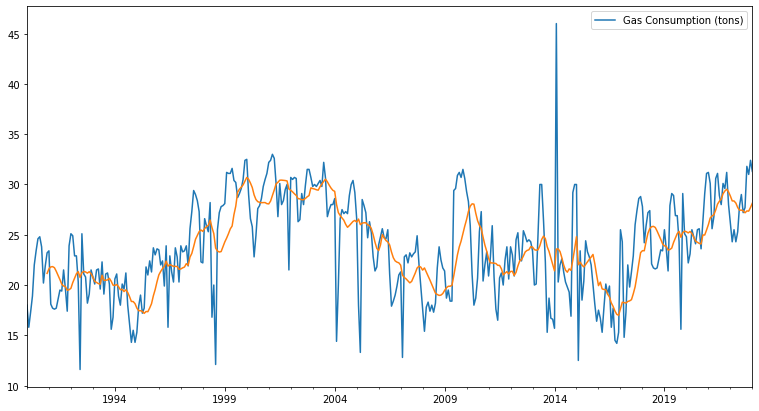

In [8]:
gas_consumption.plot(figsize=(13,7), legend=True)
gas_consumption.rolling(window=12).mean().plot()
plt.show()

# Gas Consumption Stationary Check

I used the Augmented Dickey Fuller test to check if the time series is stationary.

In [9]:
adf = adfuller(data['Gas Consumption (tons)'])
print(f"P-value:{adf[1]}")
if adf[1] < 0.05:
    print("Since P value is small (< 0.05), we reject the null hypothesis. The time series is stationary")
else:
    print("Since P value is larger than 0.05, we cannot reject the null hypothesis. The time series is non-stationary")

P-value:0.010810651707060507
Since P value is small (< 0.05), we reject the null hypothesis. The time series is stationary


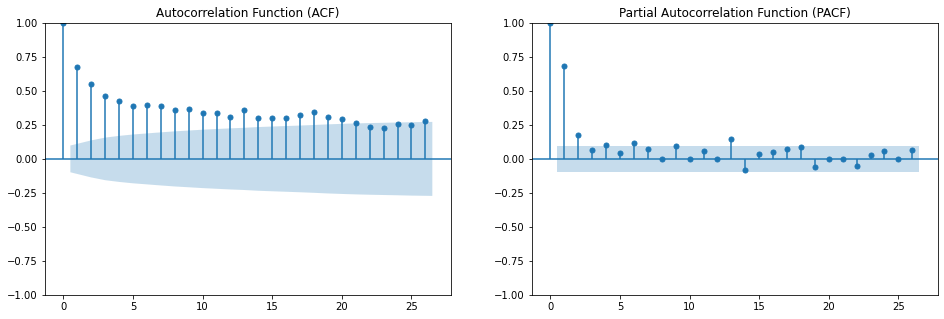

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot the ACF
plot_acf(data['Gas Consumption (tons)'], ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot the PACF
plot_pacf(data['Gas Consumption (tons)'], ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

# Display the plot
plt.show()

The ACF shows me that the time series does not have seasonality since it does not have a wave-like pattern

Since both the ACF and PACF amplitude tails off, I cannot use the ACF and PACF plot to find for AR(p) and MA(q).

# Gas Consumption Train-test split

In [11]:
# define training dataset
gc_train_data = gas_consumption[gas_consumption.index<'2020-1']
gc_test_data = gas_consumption[gas_consumption.index>='2020-1']

# Gas Consumption Holt Winters 

I used Holt Winters Linear Exponential Smoothing as the data has no seasonality

In [12]:
alpha_values = np.linspace(0.01, 0.99, num=20)
best_alpha = None
best_rmse = float('inf')

for alpha in alpha_values:
    model = ExponentialSmoothing(gc_train_data, trend='add', damped_trend=True, freq='MS')
    model_fit = model.fit(smoothing_level=alpha)
    
    # Make predictions on validation set
    pred = model_fit.forecast(steps=len(gc_test_data))
    
    # Calculate RMSE (you can choose a different metric)
    rmse = np.sqrt(mean_squared_error(gc_test_data, pred))
    
    # Update best alpha if this model has lower RMSE
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha

print("Best Alpha:", best_alpha)
print("Best RMSE:", best_rmse)

Best Alpha: 0.8352631578947368
Best RMSE: 3.5496692954990428


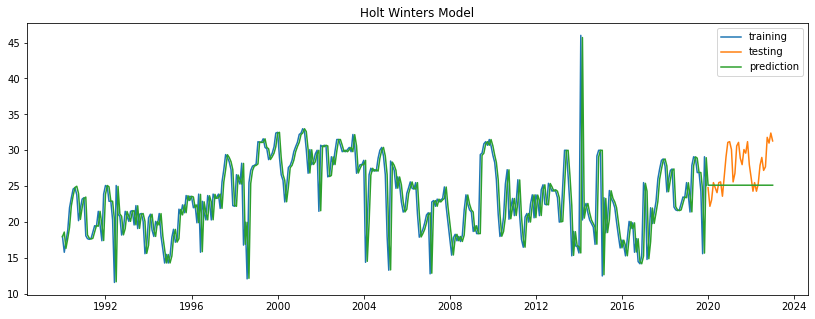

In [13]:
gc_model = ExponentialSmoothing(gc_train_data, trend='add', damped_trend=True, freq='MS').fit(smoothing_level=alpha)
gc_pred_hw = gc_model.predict(start='1990-1-1', end='2023-1-1')
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(gc_train_data, label='training')
ax.plot(gc_test_data, label='testing')
ax.plot(gc_pred_hw, label='prediction')
plt.legend()
plt.title('Holt Winters Model')
plt.show()

# Gas Consumption Holt Winters Results

In [14]:
# Evaluation
mape_train = mean_absolute_percentage_error(gc_train_data, gc_pred_hw[gc_pred_hw.index<'2020-1'])
mape_test = mean_absolute_percentage_error(gc_test_data, gc_pred_hw[gc_pred_hw.index>='2020-1'])
print(f'Model Mean Absolute Percentage Error on training data is {mape_train*100:.2f}%')
print(f'Model Mean Absolute Percentage Error on testing data is {mape_test*100:.2f}%')

mse_train = mean_squared_error(gc_train_data, gc_pred_hw[gc_pred_hw.index<'2020-1'])
mse_test = mean_squared_error(gc_test_data, gc_pred_hw[gc_pred_hw.index>='2020-1'])
print(f'\nModel Mean Squared Error on training data is {mse_train:.2f}')
print(f'Model Mean Squared Percentage Error on testing data is {mse_test:.2f}')

mae_train = mean_absolute_error(gc_train_data, gc_pred_hw[gc_pred_hw.index<'2020-1'])
mae_test = mean_absolute_error(gc_test_data, gc_pred_hw[gc_pred_hw.index>='2020-1'])
print(f'\nModel Mean Absolute Error on training data is {mae_train:.2f}')
print(f'Model Mean Absolute Error on testing data is {mae_test:.2f}')

Model Mean Absolute Percentage Error on training data is 10.92%
Model Mean Absolute Percentage Error on testing data is 10.21%

Model Mean Squared Error on training data is 16.24
Model Mean Squared Percentage Error on testing data is 13.96

Model Mean Absolute Error on training data is 2.33
Model Mean Absolute Error on testing data is 2.99


__Mean Absolute Percentage Error__

Mean Absolute Percentage Error is a metric that defines the accuracy of a forecasting or predicting method. It is calculated by adding up all the absolute percent errors together and divide the sum by the number of errors.

This means that for my model with a MAPE of 10.92% for the training data, my predictions have deviated 10.92% on average away from the true values and for my model with a MAPE of 10.21% for the test data, my predictions have deviated 10.21% on average away from the true values, thus I conclude that my model has a moderate fit on the time series

__Mean Squared Error__

Mean Squared Error(MSE) is calculated when you take the mean of the sum of squared errors, which is how far the predicted is from the actual value and square it to remove the negative. The larger the MSE, the more the data is spreaded out from the mean.

My model's train Mean Squared Error is good with a MSE of 16.24 and my model's test Mean Squared Error is good with a MSE of  13.96 which is considerably good compared to the other models, even though the MAPE is around 10-11%.

__Mean Absolute Error__

Mean Absolute Error(MAE) is calculated when you take the mean of the sum of absolute errors, which is the absolute difference of the predicted value from the actual value. MAE is similar to MSE but the difference is that it is less sensitive to outliers since instead of squaring the error, it just takes the absolute difference.

My model's train Mean Absolute Error is quite good with a MAE of 2.33 and my model's test Mean Absolute Error is quite good with a MAE of 2.99 which is considerably good compared to the other models, even though the MAPE is around 10-11%.

For my MAE and MSE this could be due to the low scale of the gas consumption data which gives a false scale of MSE and MAE being good.

# Gas Consumption ARIMA Optimization

In [15]:
# ARIMA model
gc_arima_order = []

# Loop over AR order
for p in range(4):
    # Loop over MA order
    for q in range(4):
        try:
            # Fit model       
            results = ARIMA(gc_train_data, order=(p, 0, q)).fit()        
            
            # Make predictions
            predictions = results.get_prediction(start='1990-1-1', end='2020-1-1').predicted_mean
            
            # Calculate MAPE
            mape =  mean_absolute_percentage_error(gc_train_data, predictions[predictions.index<'2020-1'])* 100
            
            gc_arima_order.append((p, q, results.aic, results.bic, mape))
        except:
            gc_arima_order.append((p, q, None, None, None))

# Make DataFrame of model order, AIC, BIC, RMSE, and MAPE 
gc_arima = pd.DataFrame(gc_arima_order, columns=['p', 'q', 'aic', 'bic', 'mape'])

In [16]:
gc_arima_aic = gc_arima.sort_values('aic').reset_index(drop=True)
gc_arima_bic = gc_arima.sort_values('bic').reset_index(drop=True)
gc_arima_mape = gc_arima.sort_values('mape').reset_index(drop=True)

result = pd.concat([gc_arima_aic, gc_arima_bic, gc_arima_mape], axis=1, keys=['Sorted by AIC', 'Sorted by BIC', 'Sorted by MAPE'])
result

Sorted by AIC                                         Sorted by BIC     \
               p  q          aic          bic       mape             p  q   
0              2  1  1945.941243  1965.371763  11.350344             2  1   
1              3  1  1946.832374  1970.148998  11.344107             1  1   
2              2  2  1947.020105  1970.336729  11.337149             3  1   
3              1  3  1947.666008  1970.982632  11.513545             2  2   
4              2  3  1948.509053  1975.711781  11.366792             1  3   
5              3  2  1949.902019  1977.104747  11.352309             1  2   
6              3  3  1950.181191  1981.270023  11.383050             2  0   
7              1  2  1951.809828  1971.240348  11.544019             2  3   
8              1  1  1953.802218  1969.346634  11.490365             3  0   
9              2  0  1957.169636  1972.714053  11.477476             3  2   
10             3  0  1957.449177  1976.879698  11.464822             1  0   
11             1  0  1967.329863  1978.988175  11.670097             3  3   
12             0  3  1987.912836  2007.343356  12.629518             0  3   
13             0  2  2002.119136  2017.663552  13.274032             0  2   
14             0  1  2048.658617  2060.316929  14.750253             0  1   
15             0  0  2169.595835  2177.368044  18.405816             0  0   

                                        Sorted by MAPE                  \
            aic          bic       mape              p  q          aic   
0   1945.941243  1965.371763  11.350344              2  2  1947.020105   
1   1953.802218  1969.346634  11.490365              3  1  1946.832374   
2   1946.832374  1970.148998  11.344107              2  1  1945.941243   
3   1947.020105  1970.336729  11.337149              3  2  1949.902019   
4   1947.666008  1970.982632  11.513545              2  3  1948.509053   
5   1951.809828  1971.240348  11.544019              3  3  1950.181191   
6   1957.169636  1972.714053  11.477476              3  0  1957.449177   
7   1948.509053  1975.711781  11.366792              2  0  1957.169636   
8   1957.449177  1976.879698  11.464822              1  1  1953.802218   
9   1949.902019  1977.104747  11.352309              1  3  1947.666008   
10  1967.329863  1978.988175  11.670097              1  2  1951.809828   
11  1950.181191  1981.270023  11.383050              1  0  1967.329863   
12  1987.912836  2007.343356  12.629518              0  3  1987.912836   
13  2002.119136  2017.663552  13.274032              0  2  2002.119136   
14  2048.658617  2060.316929  14.750253              0  1  2048.658617   
15  2169.595835  2177.368044  18.405816              0  0  2169.595835   

                            
            bic       mape  
0   1970.336729  11.337149  
1   1970.148998  11.344107  
2   1965.371763  11.350344  
3   1977.104747  11.352309  
4   1975.711781  11.366792  
5   1981.270023  11.383050  
6   1976.879698  11.464822  
7   1972.714053  11.477476  
8   1969.346634  11.490365  
9   1970.982632  11.513545  
10  1971.240348  11.544019  
11  1978.988175  11.670097  
12  2007.343356  12.629518  
13  2017.663552  13.274032  
14  2060.316929  14.750253  
15  2177.368044  18.405816

# Gas Consumption ARIMA

I decided to use order (2,0,1) as the results were roughly the same as (2,0,2) having a higher train accuracy but lower test accuracy.

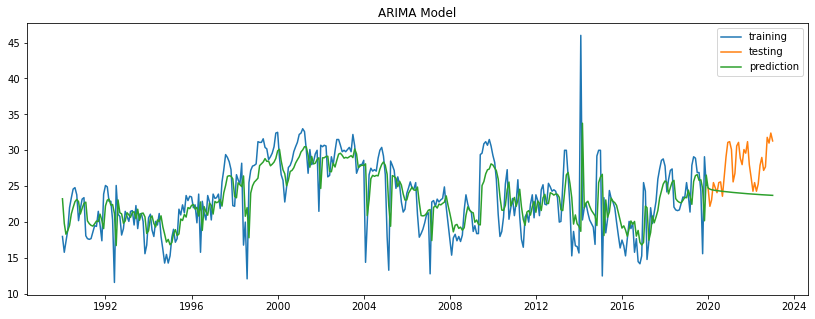

In [175]:
model = ARIMA(gc_train_data, order=(2,0,1)).fit()
pred = model.get_prediction(start='1990-1-1', end='2023-1-1').predicted_mean
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(gc_train_data, label='training')
ax.plot(gc_test_data, label='testing')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('ARIMA Model')
plt.show()

# Gas Consumption ARIMA Results

In [176]:
# Evaluation
gcari_mape_train = mean_absolute_percentage_error(gc_train_data, pred[pred.index<'2020-1'])
gcari_mape_test = mean_absolute_percentage_error(gc_test_data, pred[pred.index>='2020-1'])
print(f'Model Mean Absolute Percentage Error on training data is {gcari_mape_train*100:.2f}%')
print(f'Model Mean Absolute Percentage Error on testing data is {gcari_mape_test*100:.2f}%')

gcari_mse_train = mean_squared_error(gc_train_data, pred[pred.index<'2020-1'])
gcari_mse_test = mean_squared_error(gc_test_data, pred[pred.index>='2020-1'])
print(f'\nModel Mean Squared Error on training data is {gcari_mse_train:.2f}')
print(f'Model Mean Squared Percentage Error on testing data is {gcari_mse_test:.2f}')

gcari_mae_train = mean_absolute_error(gc_train_data, pred[pred.index<'2020-1'])
gcari_mae_test = mean_absolute_error(gc_test_data, pred[pred.index>='2020-1'])
print(f'\nModel Mean Absolute Error on training data is {gcari_mae_train:.2f}')
print(f'Model Mean Absolute Error on testing data is {gcari_mae_test:.2f}')

Model Mean Absolute Percentage Error on training data is 11.35%
Model Mean Absolute Percentage Error on testing data is 12.87%

Model Mean Squared Error on training data is 12.69
Model Mean Squared Percentage Error on testing data is 21.14

Model Mean Absolute Error on training data is 2.42
Model Mean Absolute Error on testing data is 3.77


__Mean Absolute Percentage Error__

This means that for my model with a MAPE of 11.35% for the training data, my predictions have deviated 11.35% on average away from the true values and for my model with a MAPE of 12.87% for the test data, my predictions have deviated 12.87% on average away from the true values, thus I conclude that my model has a moderate fit on the time series

__Mean Squared Error__ 

My model's train Mean Squared Error is good with a MSE of 12.69 and my model's test Mean Squared Error is good with a MSE of 21.14 which is considerably good compared to the other models, even though the MAPE is around 11-12%.

__Mean Absolute Error__

My model's train Mean Absolute Error is quite good with a MAE of 2.42 and my model's test Mean Absolute Error is quite good with a MAE of 3.77 which is considerably good compared to the other models, even though the MAPE is around 11-12%. 

For my MAE and MSE this could be due to the low scale of the gas consumption data which gives a false scale of MSE and MAE being good.

# Gas Consumption ARIMA Diagnositic plots

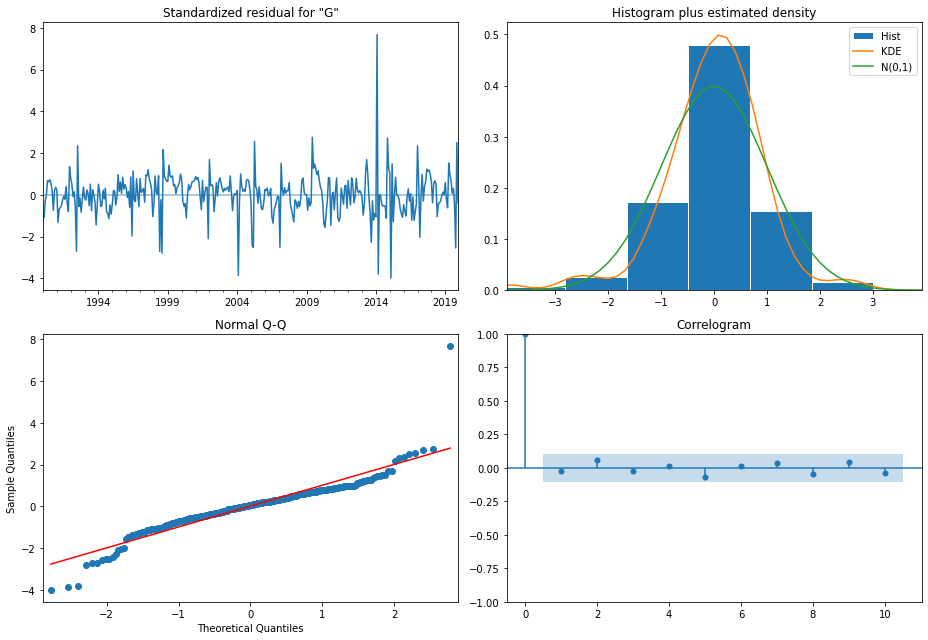

In [19]:
figure = model.plot_diagnostics()
figure.set_size_inches((13, 9))
figure.tight_layout()
plt.show()

The Histogram shows a normal distribution, the Q-Q plot shows the residuals close to the line, the Correlogram does not have any significant lags and the Residual plot has no pattern thus showing that the residuals are not correlated and that the ARIMA model is a good fit for the data

# Gas Consumption SARIMA Optimization

Since based on my background research earlier, gas consumption has a yearly trend, I set seasons to 12

In [20]:
gc_sarimax_order =[]

for p in range(4):
    for q in range(4):
        for P in range(3):
            for D in range(2):
                for Q in range(3):
                    try:
                        # Fit model       
                        results = SARIMAX(gc_train_data, order=(p,0,q),seasonal_order=(P,D,Q,12)).fit()        
                        
                        # Make predictions
                        predictions = results.get_prediction(start='1990-1-1', end='2020-1-1').predicted_mean
            
                        # Calculate MAPE
                        mape =  mean_absolute_percentage_error(gc_train_data, predictions[predictions.index<'2020-1'])* 100  
                       
                        gc_sarimax_order.append((p, q, P, D, Q, results.aic, results.bic, mape))
                    
                    except:
                        gc_sarimax_order.append((p, q, P, D, Q, None, None, None))
            

# Make DataFrame of model order and AIC/BIC 
gc_sarimax = pd.DataFrame(gc_sarimax_order, columns=['p','q','P','D','Q','aic', 'bic','mape'])

In [21]:
gc_sarimax_aic = gc_sarimax.sort_values('aic').reset_index(drop=True)
gc_sarimax_bic = gc_sarimax.sort_values('bic').reset_index(drop=True)
gc_sarimax_mape = gc_sarimax.sort_values('mape').reset_index(drop=True)

result = pd.concat([gc_sarimax_aic, gc_sarimax_bic], axis=1, keys=['Sorted by AIC', 'Sorted by BIC', 'Sorted by MAPE'])
result


Sorted by AIC                                                    \
                p  q  P  D  Q          aic          bic        mape   
0               2  1  1  1  1  1922.065827  1945.179042   14.896088   
1               2  1  0  1  2  1922.396502  1945.509717   14.900554   
2               2  1  2  1  1  1923.621025  1950.586443   14.905198   
3               3  1  1  1  1  1923.729095  1950.694513   14.892743   
4               2  1  0  1  1  1923.826647  1943.087659   14.986311   
..            ... .. .. .. ..          ...          ...         ...   
283             0  0  0  0  1  2984.076097  2991.848305   57.957132   
284             0  0  0  0  0  3308.870931  3312.757035  100.000000   
285             0  1  2  0  1          NaN          NaN         NaN   
286             0  2  2  0  1          NaN          NaN         NaN   
287             0  3  2  0  1          NaN          NaN         NaN   

    Sorted by BIC                                                    
                p  q  P  D  Q          aic          bic        mape  
0               2  1  0  1  1  1923.826647  1943.087659   14.986311  
1               2  1  1  1  1  1922.065827  1945.179042   14.896088  
2               2  1  0  1  2  1922.396502  1945.509717   14.900554  
3               3  1  0  1  1  1924.848287  1947.961501   15.000381  
4               1  3  0  1  1  1925.662046  1948.775261   15.133784  
..            ... .. .. .. ..          ...          ...         ...  
283             0  0  0  0  1  2984.076097  2991.848305   57.957132  
284             0  0  0  0  0  3308.870931  3312.757035  100.000000  
285             0  1  2  0  1          NaN          NaN         NaN  
286             0  2  2  0  1          NaN          NaN         NaN  
287             0  3  2  0  1          NaN          NaN         NaN  

[288 rows x 16 columns]

In [22]:
print("Sorted by MAPE:")
gc_sarimax_mape

Sorted by MAPE:


,p,q,P,D,Q,aic,bic,mape
0,2,1,2,0,2,1951.156671,1982.245503,11.111236
1,2,0,2,0,2,1995.794271,2022.996999,11.164364
2,3,0,2,0,2,1987.458271,2018.547103,11.210375
3,1,0,2,0,1,2032.127538,2051.558058,11.211746
4,1,0,1,0,2,2032.734076,2052.164597,11.212509
...,...,...,...,...,...,...,...,...
283,0,0,0,0,1,2984.076097,2991.848305,57.957132
284,0,0,0,0,0,3308.870931,3312.757035,100.000000
285,0,1,2,0,1,NaN,NaN,NaN
286,0,2,2,0,1,NaN,NaN,NaN


# Gas Consumption SARIMA

In [187]:
model = SARIMAX(gc_train_data, order=(2,0,1),seasonal_order=(1,1,1,12)).fit()
pred = model.get_prediction(start='1990-1-1', end='2023-1-1').predicted_mean
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:             Gas Consumption (tons)   No. Observations:                  360
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -955.033
Date:                            Fri, 11 Aug 2023   AIC                           1922.066
Time:                                    21:00:32   BIC                           1945.179
Sample:                                01-01-1990   HQIC                          1931.268
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4015      0.057     24.438      0.000       1.289       1.514
ar.L2         -0.4110      0.050   

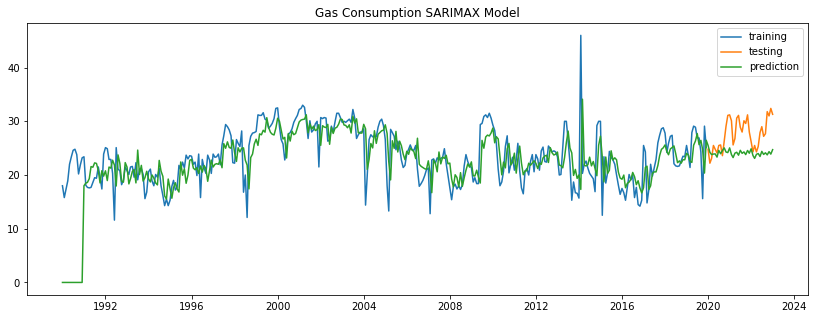

In [188]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(gc_train_data, label='training')
ax.plot(gc_test_data, label='testing')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('Gas Consumption SARIMAX Model')
plt.show()


# Gas Consumption SARIMA Results

In [189]:
# Evaluation
gcsari_mape_train = mean_absolute_percentage_error(gc_train_data, pred[pred.index<'2020-1'])
gcsari_mape_test = mean_absolute_percentage_error(gc_test_data, pred[pred.index>='2020-1'])
print(f'Model Mean Absolute Percentage Error on training data is {gcsari_mape_train*100:.2f}%')
print(f'Model Mean Absolute Percentage Error on testing data is {gcsari_mape_test*100:.2f}%')

gcsari_mse_train = mean_squared_error(gc_train_data, pred[pred.index<'2020-1'])
gcsari_mse_test = mean_squared_error(gc_test_data, pred[pred.index>='2020-1'])
print(f'\nModel Mean Squared Error on training data is {gcsari_mse_train:.2f}')
print(f'Model Mean Squared Percentage Error on testing data is {gcsari_mse_test:.2f}')

gcsari_mae_train = mean_absolute_error(gc_train_data, pred[pred.index<'2020-1'])
gcsari_mae_test = mean_absolute_error(gc_test_data, pred[pred.index>='2020-1'])
print(f'\nModel Mean Absolute Error on training data is {gcsari_mae_train:.2f}')
print(f'Model Mean Absolute Error on testing data is {gcsari_mae_test:.2f}')

Model Mean Absolute Percentage Error on training data is 14.90%
Model Mean Absolute Percentage Error on testing data is 12.67%

Model Mean Squared Error on training data is 28.53
Model Mean Squared Percentage Error on testing data is 19.80

Model Mean Absolute Error on training data is 3.20
Model Mean Absolute Error on testing data is 3.70


__Mean Absolute Percentage Error__

This means that for my model with a MAPE of 14.90% for the training data, my predictions have deviated 14.90% on average away from the true values and for my model with a MAPE of 12.67% for the test data, my predictions have deviated 12.67% on average away from the true values, thus I conclude that my model has a moderate fit on the time series

__Mean Squared Error__ 

My model's train Mean Squared Error is good with a MSE of 28.53 and my model's test Mean Squared Error is good with a MSE of 19.80 which is moderate considering the scale of gas consumption even though the MAPE is around 11-12%.

__Mean Absolute Error__

My model's train Mean Absolute Error is quite good with a MAE of 3.20 and my model's test Mean Absolute Error is quite good with a MAE of 3.70 which is pretty good even after considering the scale of gas consumption.

For my MAE and MSE this could be due to the low scale of the gas consumption data which gives a false scale of MSE and MAE being good.

# Gas Consumption SARIMA Diagnositic plots

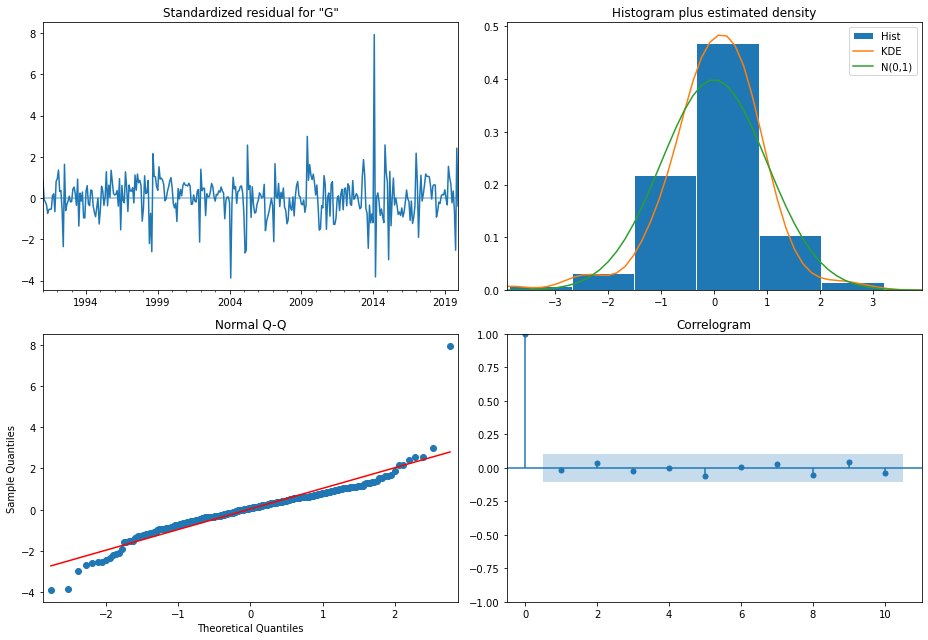

In [190]:
figure = model.plot_diagnostics()
figure.set_size_inches((13, 9))
figure.tight_layout()
plt.show()

The Histogram shows a normal distribution, the Q-Q plot shows the residuals close to the line, the Correlogram does not have any significant lags and the Residual plot has no pattern thus showing that the residuals are not correlated and that the SARIMA model is a good fit for the data

# Gas Consumption ARIMA VS SARIMA

In [181]:
gc_comparision_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA'],
    'MAPE':[ gcari_mape_test*100, gcsari_mape_test*100],
    'MAE': [gcari_mae_test, gcsari_mae_test],
    'MSE': [gcari_mse_test, gcsari_mse_test]
})
gc_comparision_df

,Model,MAPE,MAE,MSE
0,ARIMA,12.870089,3.767569,21.135383
1,SARIMA,12.667393,3.697536,19.798525


From this table, I can see that SARIMA outperforms ARIMA just slightly. This is surprising as the ACF plot shows that the data does not have seasonality yet SARIMA still performed better which could be due to the SARIMA model picking underlying seasonality in the data, since I did background research and found out gas consumption has seasonality in some countries

# Gas Consumption Overall Comparison

Overall, Holt winters surprising outperformed ARIMA and SARIMA with a MAPE of 10.92% on the train and a MAPE of 10.21% on the test, a MSE of 16.24 on the train and a MSE of 13.96 on the test and a MAE of 2.33 on the train and a MAE of 2.99 on the test

# Electricity Consumption

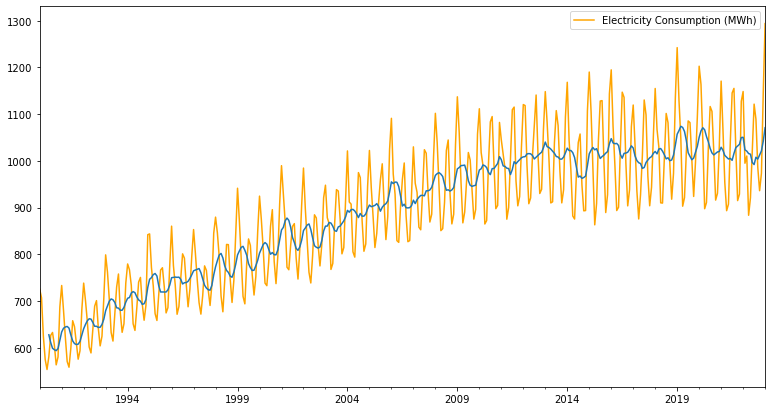

In [26]:
data['Electricity Consumption (MWh)'].plot(figsize=(13,7), legend=True, color='orange')
data['Electricity Consumption (MWh)'].rolling(window=6).mean().plot()
plt.show()

# Electricity Consumption Stationary Check

In [27]:
adf = adfuller(electricity_consumption)
print(f"P-value:{adf[1]}")
if adf[1] < 0.05:
    print("Since P value is small (< 0.05), we reject the null hypothesis. The time series is stationary")
else:
    print("Since P value is larger than 0.05, we cannot reject the null hypothesis. The time series is non-stationary")

P-value:0.18621802300336632
Since P value is larger than 0.05, we cannot reject the null hypothesis. The time series is non-stationary


Since the time series is non-stationary, I differenced the time series to make it stationary

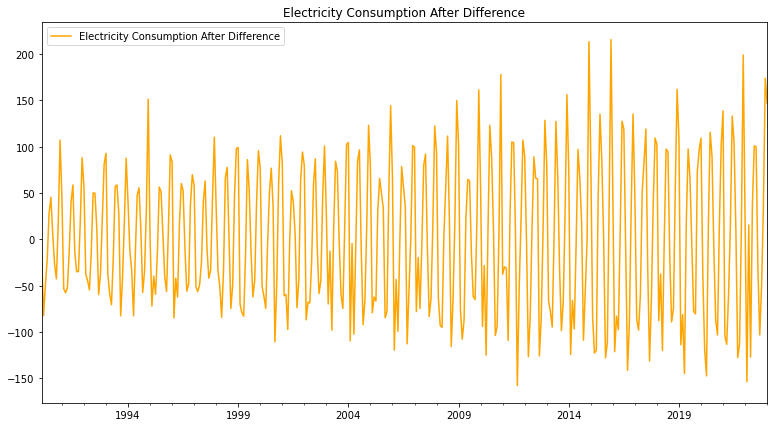

In [28]:
ec_diff = diff(electricity_consumption,k_diff=1)
ec_diff.dropna(inplace=True)
ec_diff.plot(figsize=(13,7), legend=True, color='orange',label="Electricity Consumption After Difference")
plt.title("Electricity Consumption After Difference")
plt.show()

In [29]:
adf = adfuller(ec_diff)
print(f"P-value:{adf[1]}")
if adf[1] < 0.05:
    print("Since P value is small (< 0.05), we reject the null hypothesis. The time series is stationary")
else:
    print("Since P value is larger than 0.05, we cannot reject the null hypothesis. The time series is non-stationary")

P-value:4.079770743785098e-10
Since P value is small (< 0.05), we reject the null hypothesis. The time series is stationary


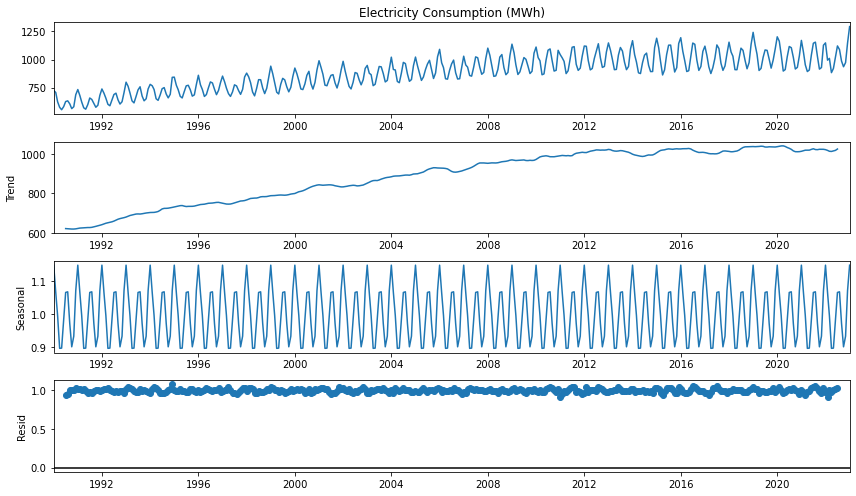

In [191]:
sd = seasonal_decompose(electricity_consumption, model='multplicative', period=12)
figure = sd.plot()
figure.set_size_inches((12, 7))
figure.tight_layout()
plt.show()

From the seasonal decomposition plot, I can tell that the trend of the data is overall going up and that the seasonality is 12. The residual plot shows all the plot around 1 which is correct in a multiplicative which shows that the model is accurately capturing the seasonality

# ACF and PACF

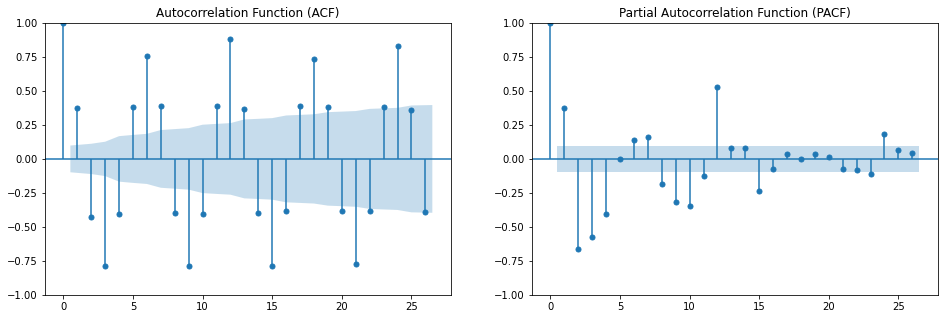

In [31]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot the ACF
plot_acf(ec_diff, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot the PACF
plot_pacf(ec_diff, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.show()

I plotted the ACF with the differenced data since it is easier to see the patterns without the trend of the time series 

From the ACF I can tell that there is seasonality present in this time series. The lag has at 6 and 12 with a slightly more significant spike every 12 lags. The pacf also shows that there is a significant spike at lag 12 thus I can deduce that the peroid of this time series is 12

# Electricity Consumption Train-test split

In [32]:
# define training dataset
ec_train_data = electricity_consumption[electricity_consumption.index<'2020-1']
ec_test_data = electricity_consumption[electricity_consumption.index>='2020-1']

# Electricity Consumption ARIMA Optimization

In [33]:
# ARIMA model
ec_arima_order =[]
# Loop over AR order
for p in range(4):
    # Loop over MA order
    for q in range(4):
        try:
            # Fit model       
            results = ARIMA(ec_train_data, order=(p,1,q)).fit()     
            
            # Make predictions
            predictions = results.get_prediction(start='1990-1-1', end='2020-1-1').predicted_mean
            
            # Calculate MAPE
            mape =  mean_absolute_percentage_error(ec_train_data, predictions[predictions.index<'2020-1'])* 100 
            
            ec_arima_order.append((p, q, results.aic, results.bic, mape))
        except:
            ec_arima_order.append((p, q, None, None, None))

# Make DataFrame of model order and AIC/BIC 
ec_arima = pd.DataFrame(ec_arima_order, columns=['p','q','aic','bic','mape'])

In [34]:
ec_arima_aic = ec_arima.sort_values('aic').reset_index(drop=True)
ec_arima_bic = ec_arima.sort_values('bic').reset_index(drop=True)
ec_arima_mape = ec_arima.sort_values('mape').reset_index(drop=True)

result = pd.concat([ec_arima_aic, ec_arima_bic, ec_arima_mape], axis=1, keys=['Sorted by AIC', 'Sorted by BIC','Sorted by MAPE'])
result

Sorted by AIC                                        Sorted by BIC     \
               p  q          aic          bic      mape             p  q   
0              2  3  3526.117502  3549.417436  3.179091             2  3   
1              3  2  3530.101135  3553.401069  3.178404             2  2   
2              2  2  3532.925853  3552.342465  3.168729             3  2   
3              3  3  3546.670080  3573.853337  3.164680             3  3   
4              3  1  3641.142751  3660.559363  3.626226             3  1   
5              2  1  3658.719448  3674.252737  3.642775             2  1   
6              3  0  3702.335270  3717.868560  3.945165             3  0   
7              2  0  3849.633456  3861.283423  4.650048             2  0   
8              1  3  3853.118344  3872.534956  4.916403             0  3   
9              0  3  3853.150195  3868.683484  4.942554             1  3   
10             1  2  3892.607320  3908.140610  5.107495             1  2   
11             0  2  3923.349796  3934.999764  5.297205             0  2   
12             0  1  4001.879047  4009.645692  6.170418             0  1   
13             1  1  4002.979632  4014.629599  6.147230             1  1   
14             1  0  4066.028071  4073.794715  6.804599             1  0   
15             0  0  4118.892457  4122.775779  7.461738             0  0   

                                       Sorted by MAPE                  \
            aic          bic      mape              p  q          aic   
0   3526.117502  3549.417436  3.179091              3  3  3546.670080   
1   3532.925853  3552.342465  3.168729              2  2  3532.925853   
2   3530.101135  3553.401069  3.178404              3  2  3530.101135   
3   3546.670080  3573.853337  3.164680              2  3  3526.117502   
4   3641.142751  3660.559363  3.626226              3  1  3641.142751   
5   3658.719448  3674.252737  3.642775              2  1  3658.719448   
6   3702.335270  3717.868560  3.945165              3  0  3702.335270   
7   3849.633456  3861.283423  4.650048              2  0  3849.633456   
8   3853.150195  3868.683484  4.942554              1  3  3853.118344   
9   3853.118344  3872.534956  4.916403              0  3  3853.150195   
10  3892.607320  3908.140610  5.107495              1  2  3892.607320   
11  3923.349796  3934.999764  5.297205              0  2  3923.349796   
12  4001.879047  4009.645692  6.170418              1  1  4002.979632   
13  4002.979632  4014.629599  6.147230              0  1  4001.879047   
14  4066.028071  4073.794715  6.804599              1  0  4066.028071   
15  4118.892457  4122.775779  7.461738              0  0  4118.892457   

                           
            bic      mape  
0   3573.853337  3.164680  
1   3552.342465  3.168729  
2   3553.401069  3.178404  
3   3549.417436  3.179091  
4   3660.559363  3.626226  
5   3674.252737  3.642775  
6   3717.868560  3.945165  
7   3861.283423  4.650048  
8   3872.534956  4.916403  
9   3868.683484  4.942554  
10  3908.140610  5.107495  
11  3934.999764  5.297205  
12  4014.629599  6.147230  
13  4009.645692  6.170418  
14  4073.794715  6.804599  
15  4122.775779  7.461738

# Electricity Consumption ARIMA

I decided to use the order=(2,1,3) as it has the overall best accuracy

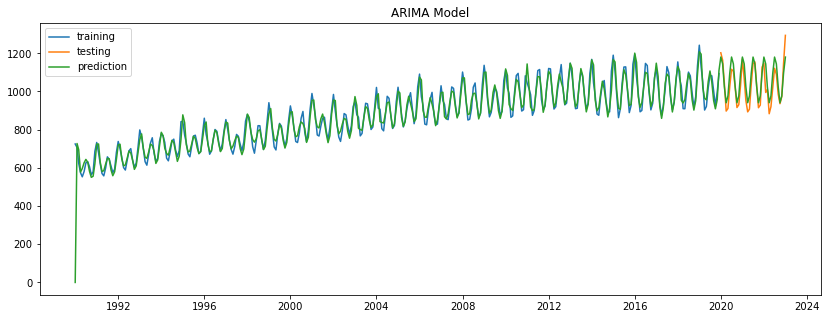

In [149]:
ec_model = ARIMA(ec_train_data, order=(2,1,3)).fit()
pred = ec_model.get_prediction(start='1990-1-1', end='2023-1-1').predicted_mean
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(ec_train_data, label='training')
ax.plot(ec_test_data, label='testing')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('ARIMA Model')
plt.show()

# Electricity Consumption ARIMA Results

In [150]:
# Evaluation
ecari_mape_train = mean_absolute_percentage_error(ec_train_data, pred[pred.index<'2020-1'])
ecari_mape_test = mean_absolute_percentage_error(ec_test_data, pred[pred.index>='2020-1'])
print(f'Model Mean Absolute Percentage Error on training data is {ecari_mape_train*100:.2f}%')
print(f'Model Mean Absolute Percentage Error on testing data is {ecari_mape_test*100:.2f}%')

ecari_mse_train = mean_squared_error(ec_train_data, pred[pred.index<'2020-1'])
ecari_mse_test = mean_squared_error(ec_test_data, pred[pred.index>='2020-1'])
print(f'\nModel Mean Squared Error on training data is {ecari_mse_train:.2f}')
print(f'Model Mean Squared Percentage Error on testing data is {ecari_mse_test:.2f}')

ecari_mae_train = mean_absolute_error(ec_train_data, pred[pred.index<'2020-1'])
ecari_mae_test = mean_absolute_error(ec_test_data, pred[pred.index>='2020-1'])
print(f'\nModel Mean Absolute Error on training data is {ecari_mae_train:.2f}')
print(f'Model Mean Absolute Error on testing data is {ecari_mae_test:.2f}')

Model Mean Absolute Percentage Error on training data is 3.18%
Model Mean Absolute Percentage Error on testing data is 4.45%

Model Mean Squared Error on training data is 2496.36
Model Mean Squared Percentage Error on testing data is 3000.83

Model Mean Absolute Error on training data is 27.39
Model Mean Absolute Error on testing data is 45.44


__Mean Absolute Percentage Error__

This means that for my model with a MAPE of 3.18% for the training data, my predictions have deviated 3.18% on average away from the true values and for my model with a MAPE of 4.45% for the test data, my predictions have deviated 4.45% on average away from the true values, thus I conclude that my model has a very good fit on the time series

__Mean Squared Error__ 

My model's train Mean Squared Error is good with a MSE of 2496.3 and my model's test Mean Squared Error is good with a MSE of 3000.8

__Mean Absolute Error__

My model's train Mean Absolute Error is quite good with a MAE of 27.39 and my model's test Mean Absolute Error is quite good with a MAE of 45.44

# Electriticty Consumption ARIMA Diagnostic Plot

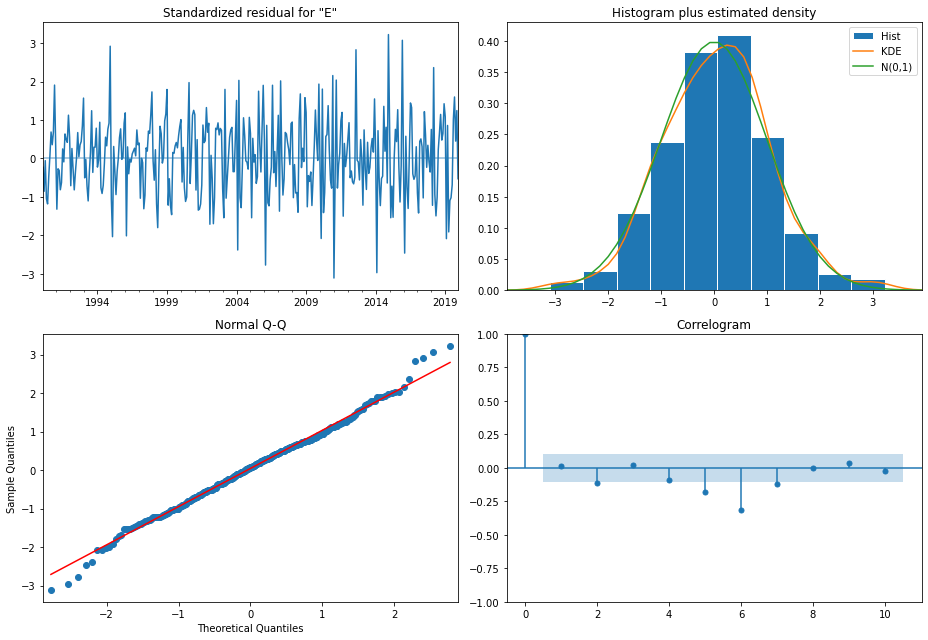

In [37]:
figure = ec_model.plot_diagnostics()
figure.set_size_inches((13, 9))
figure.tight_layout()
plt.show()

The Histogram shows a normal distribution, the Q-Q plot shows the residuals close to the line and the Residual plot has no pattern. However the Correlogram has a significant lag which shows that the ARIMA model might not be the best fit for this data which is expected since this data has seasonality.

# Seasonal Differencing

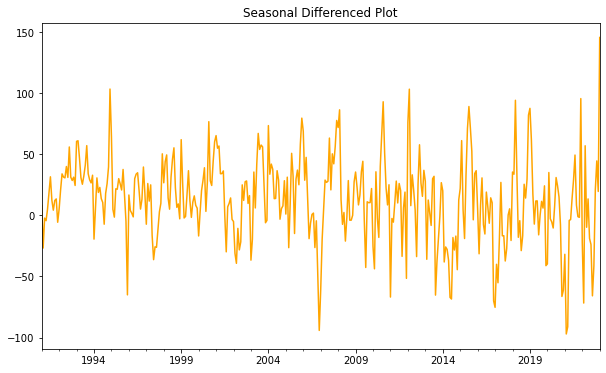

In [38]:
ec_sdiff = electricity_consumption.diff(12)
ec_sdiff.dropna(inplace=True)
ec_sdiff.plot(figsize=(10,6), color='orange')
plt.title("Seasonal Differenced Plot")
plt.show()

Since the data shows that there is no trend, in theory, the seasonal difference in the arima model should be 1

In [39]:
#Checking if data is stationary
adf = adfuller(ec_sdiff)
print(f"P-value:{adf[1]}")
if adf[1] < 0.05:
    print("Since P value is small (< 0.05), we reject the null hypothesis. The time series is stationary")
else:
    print("Since P value is larger than 0.05, we cannot reject the null hypothesis. The time series is non-stationary")

P-value:8.818867458790871e-07
Since P value is small (< 0.05), we reject the null hypothesis. The time series is stationary


# Seasonal ACF and PACF (SARIMA)

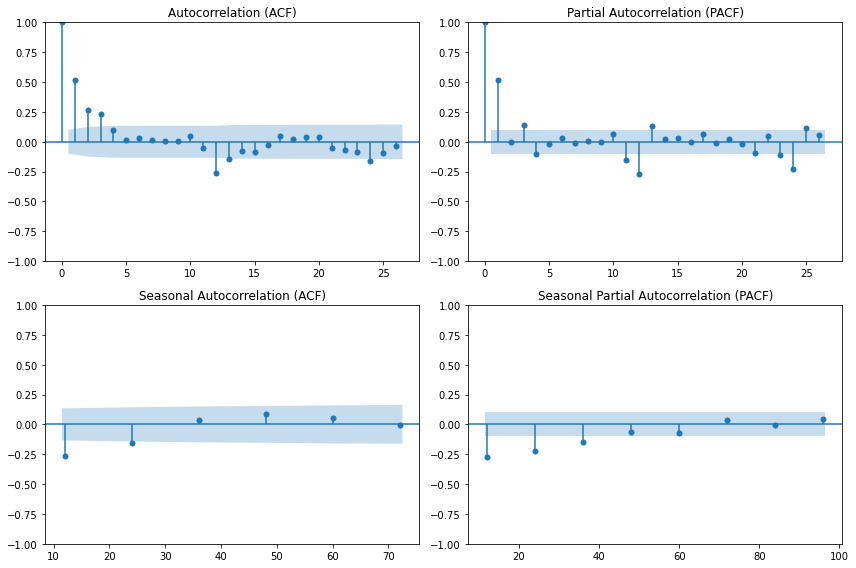

In [40]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Plot seasonal ACF
plot_acf(ec_sdiff, ax=ax1)
ax1.set_title('Autocorrelation (ACF)')

# Plot seasonal PACF
plot_pacf(ec_sdiff, ax=ax2)
ax2.set_title('Partial Autocorrelation (PACF)')

# Plot seasonal ACF with specific lags
plot_acf(ec_sdiff, lags=[12, 24, 36, 48, 60, 72], ax=ax3)
ax3.set_title('Seasonal Autocorrelation (ACF)')

# Plot seasonal PACF with specific lags
plot_pacf(ec_sdiff, lags=[12, 24, 36, 48, 60, 72, 84, 96], ax=ax4)
ax4.set_title('Seasonal Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.show()

Althought ACF and PACF is unreliable, since on the PACF, there is a cut off at lag 3 this could suggest a AR(q) value of 3. From the ACF plot the lag is signifcant at 4 thus this could suggest a MA(q) value of 4. 

From the seasonal ACF and PACF, both amplitudes tails off with increasing lag thus I can't deduce seasonal AR(P) and seasonal MA(Q) from this model

# Electricity Consumption SARIMAX Optimization

In [41]:
ec_sarimax_order =[]
# Loop over AR order
for p in range(4):
    for q in range(4):
        for P in range(3):
            for D in range(2):
                for Q in range(3):
                    try:
                        # Fit model       
                        results = SARIMAX(ec_train_data, order=(p,1,q),seasonal_order=(P,D,Q,12)).fit()  
                        
                        # Make predictions
                        predictions = results.get_prediction(start='1990-1-1', end='2020-1-1').predicted_mean
            
                        # Calculate MAPE
                        mape =  mean_absolute_percentage_error(ec_train_data, predictions[predictions.index<'2020-1'])* 100
                    
                        ec_sarimax_order.append((p, q, P, D, Q, results.aic, results.bic, mape))
                    
                    except:
                        ec_sarimax_order.append((p, q, P, D, Q, None, None, None))

                        

# Make DataFrame of model order and AIC/BIC 
ec_sarimax = pd.DataFrame(ec_sarimax_order, columns=['p','q','P','D','Q','aic', 'bic','mape'])

In [42]:
ec_sarimax_aic = ec_sarimax.sort_values('aic').reset_index(drop=True)
ec_sarimax_bic = ec_sarimax.sort_values('bic').reset_index(drop=True)
ec_sarimax_mape = ec_sarimax.sort_values('mape').reset_index(drop=True)

result = pd.concat([ec_sarimax_aic, ec_sarimax_bic], axis=1, keys=['Sorted by AIC', 'Sorted by BIC'])
result

Sorted by AIC                                                  \
                p  q  P  D  Q          aic          bic      mape   
0               3  3  2  1  2  3154.747490  3197.090062  2.427185   
1               2  3  2  1  2  3156.146409  3194.639657  2.438965   
2               2  3  2  1  1  3157.074945  3191.718868  2.440951   
3               3  2  2  1  2  3157.354428  3195.847676  2.440839   
4               1  1  2  1  1  3157.640126  3180.736074  2.451450   
..            ... .. .. .. ..          ...          ...       ...   
283             1  0  2  0  1          NaN          NaN       NaN   
284             1  2  2  0  2          NaN          NaN       NaN   
285             3  1  2  0  1          NaN          NaN       NaN   
286             3  2  2  0  2          NaN          NaN       NaN   
287             3  3  2  0  2          NaN          NaN       NaN   

    Sorted by BIC                                                  
                p  q  P  D  Q          aic          bic      mape  
0               1  1  0  1  1  3163.023926  3178.421225  2.481326  
1               1  1  2  1  1  3157.640126  3180.736074  2.451450  
2               1  2  0  1  1  3163.144080  3182.390704  2.478347  
3               2  1  0  1  1  3163.374486  3182.621110  2.478830  
4               1  1  0  1  2  3163.406307  3182.652931  2.479680  
..            ... .. .. .. ..          ...          ...       ...  
283             1  0  2  0  1          NaN          NaN       NaN  
284             1  2  2  0  2          NaN          NaN       NaN  
285             3  1  2  0  1          NaN          NaN       NaN  
286             3  2  2  0  2          NaN          NaN       NaN  
287             3  3  2  0  2          NaN          NaN       NaN  

[288 rows x 16 columns]

In [43]:
print("Sorted by MAPE:")
ec_sarimax_mape

Sorted by MAPE:


,p,q,P,D,Q,aic,bic,mape
0,3,2,1,0,1,3324.025825,3355.092404,2.333230
1,2,3,1,0,1,3314.014776,3345.081355,2.338590
2,2,3,2,0,1,3314.155627,3349.105529,2.341041
3,3,2,2,0,1,3324.437072,3359.386973,2.342215
4,2,2,2,0,1,3335.154154,3366.220734,2.344289
...,...,...,...,...,...,...,...,...
283,1,0,2,0,1,NaN,NaN,NaN
284,1,2,2,0,2,NaN,NaN,NaN
285,3,1,2,0,1,NaN,NaN,NaN
286,3,2,2,0,2,NaN,NaN,NaN


# Electricity Consumption SARIMA

I decided to use order=(3,1,3) and seasonal order=(2,1,2,12) as it gave the best accuracy. The seasonal differencing was 1 which coincides with the seasonal acf that I plotted.

In [238]:
model = SARIMAX(ec_train_data, order=(3,1,3),seasonal_order=(2,1,2,12)).fit()
ecsari_pred = model.get_prediction(start='1990-1-1', end='2023-1-1').predicted_mean
print(model.summary())

                                        SARIMAX Results                                        
Dep. Variable:           Electricity Consumption (MWh)   No. Observations:                  360
Model:             SARIMAX(3, 1, 3)x(2, 1, [1, 2], 12)   Log Likelihood               -1566.374
Date:                                 Fri, 11 Aug 2023   AIC                           3154.747
Time:                                         23:26:21   BIC                           3197.090
Sample:                                     01-01-1990   HQIC                          3171.607
                                          - 12-01-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2256      0.173     -7.080      0.000      -1.565      -0

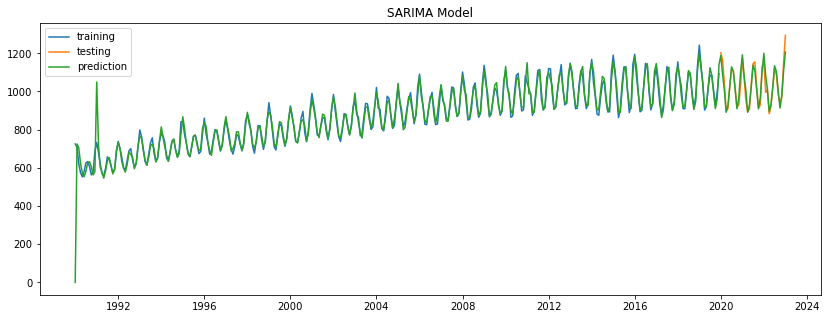

In [239]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(ec_train_data, label='training')
ax.plot(ec_test_data, label='testing')
ax.plot(ecsari_pred, label='prediction')
plt.legend()
plt.title('SARIMA Model')
plt.show()


# Electricity Consumption SARIMA Results

In [240]:
# Evaluation
ecsari_mape_train = mean_absolute_percentage_error(ec_train_data, ecsari_pred[ecsari_pred.index<'2020-1'])
ecsari_mape_test = mean_absolute_percentage_error(ec_test_data, ecsari_pred[ecsari_pred.index>='2020-1'])
print(f'Model Mean Absolute Percentage Error on training data is {ecsari_mape_train*100:.2f}%')
print(f'Model Mean Absolute Percentage Error on testing data is {ecsari_mape_test*100:.2f}%')

ecsari_mse_train = mean_squared_error(ec_train_data, ecsari_pred[ecsari_pred.index<'2020-1'])
ecsari_mse_test = mean_squared_error(ec_test_data, ecsari_pred[ecsari_pred.index>='2020-1'])
print(f'\nModel Mean Squared Error on training data is {ecsari_mse_train:.2f}')
print(f'Model Mean Squared Percentage Error on testing data is {ecsari_mse_test:.2f}')

ecsari_mae_train = mean_absolute_error(ec_train_data, ecsari_pred[ecsari_pred.index<'2020-1'])
ecsari_mae_test = mean_absolute_error(ec_test_data, ecsari_pred[ecsari_pred.index>='2020-1'])
print(f'\nModel Mean Absolute Error on training data is {ecsari_mae_train:.2f}')
print(f'Model Mean Absolute Error on testing data is {ecsari_mae_test:.2f}')

Model Mean Absolute Percentage Error on training data is 2.43%
Model Mean Absolute Percentage Error on testing data is 2.37%

Model Mean Squared Error on training data is 2275.26
Model Mean Squared Percentage Error on testing data is 1194.07

Model Mean Absolute Error on training data is 20.54
Model Mean Absolute Error on testing data is 25.05


__Mean Absolute Percentage Error__

This means that for my model with a MAPE of 2.43% for the training data, my predictions have deviated 2.43% on average away from the true values and for my model with a MAPE of 2.37% for the test data, my predictions have deviated 2.37% on average away from the true values, thus I conclude that my model has a very good fit on the time series. The reason why test might be better than train is due to the weird spike in the prediction found in the train side.

__Mean Squared Error__ 

My model's train Mean Squared Error is good with a MSE of 2275.26 and my model's test Mean Squared Error is good with a MSE of 1194.07

__Mean Absolute Error__

My model's train Mean Absolute Error is quite good with a MAE of 20.52 and my model's test Mean Absolute Error is quite good with a MAE of 30.6

# Electricity Consumption SARIMA Diagnostic Plot

figure = model.plot_diagnostics()
figure.set_size_inches((13, 9))
figure.tight_layout()
plt.show()

# Electricity Consumption ARIMA VS SARIMA

In [155]:
ec_comparision_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA'],
    'MAPE':[ ecari_mape_test*100, ecsari_mape_test*100],
    'MAE': [ecari_mae_test, ecsari_mae_test],
    'MSE': [ecari_mse_test, ecsari_mse_test]
})
ec_comparision_df

,Model,MAPE,MAE,MSE
0,ARIMA,4.449690,45.438150,3000.834460
1,SARIMA,2.371245,25.052907,1194.073956


From this table, I can see that the SARIMA model outperforms the ARIMA on the logged electricity consumption data which is expected since electricity consumption data have seasonality

# Logged Electricity Consumption

I decided to log the data since it seems to be multiplicative as the magnitude of the seasons increases as the trend increases. This makes the data become additive and so i can hopefully use arima and sarimax to predict the values more effectively.

In [48]:
log_ec = np.log(electricity_consumption)
# define training dataset
logec_train_data = log_ec[log_ec.index<'2020-1']
logec_test_data = log_ec[log_ec.index>='2020-1']

# Original VS Logged

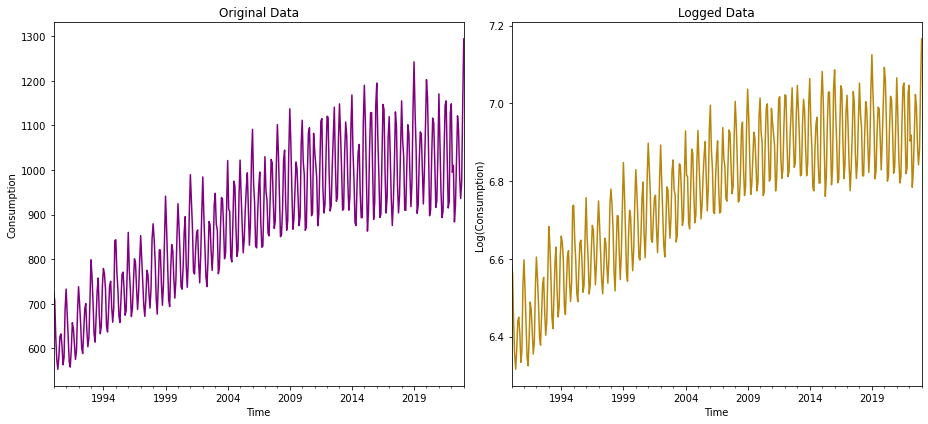

In [49]:
plt.figure(figsize=(13, 6))


plt.subplot(1, 2, 1)
electricity_consumption.plot(color='purple')
plt.title('Original Data') 
plt.xlabel('Time')  
plt.ylabel('Consumption')  


plt.subplot(1, 2, 2)
log_ec.plot(color='darkgoldenrod')  
plt.title('Logged Data') 
plt.xlabel('Time') 
plt.ylabel('Log(Consumption)')

plt.tight_layout()
plt.show()

From this graphs, I can see that the original data's seasonal amplitude increases as the trend increases which shows a multiplicative time series. After logging, the data's amplitude does not seem to increase with the trend thus making it a additive model.

In [50]:
adf = adfuller(log_ec)
print(f"P-value:{adf[1]}")
if adf[1] < 0.05:
    print("Since P value is small (< 0.05), we reject the null hypothesis. The time series is stationary")
else:
    print("Since P value is larger than 0.05, we cannot reject the null hypothesis. The time series is non-stationary")

P-value:0.023375186433001228
Since P value is small (< 0.05), we reject the null hypothesis. The time series is stationary


# Logged ARIMA Optimization

In [51]:
# ARIMA model
log_ec_arima_order = []
# Loop over AR order
for p in range(4):
    # Loop over MA order
    for q in range(4):
        try:
            # Fit model       
            results = ARIMA(logec_train_data, order=(p, 0, q)).fit()      
            
            # Make predictions
            predictions = results.get_prediction(start='1990-1-1', end='2020-1-1').predicted_mean
            
            # Calculate MAPE
            mape =  mean_absolute_percentage_error(logec_train_data, predictions[predictions.index<'2020-1'])* 100
            
            log_ec_arima_order.append((p, q, results.aic, results.bic, mape))
        except:
            log_ec_arima_order.append((p, q, None, None, None))

# Make DataFrame of model order, AIC, BIC, RMSE, and MAPE 
log_ec_arima = pd.DataFrame(log_ec_arima_order, columns=['p', 'q', 'aic', 'bic','mape'])

In [52]:
log_ec_arima_aic = log_ec_arima.sort_values('aic').reset_index(drop=True)
log_ec_arima_bic = log_ec_arima.sort_values('bic').reset_index(drop=True)
log_ec_arima_mape = log_ec_arima.sort_values('mape').reset_index(drop=True)


result = pd.concat([log_ec_arima_aic, log_ec_arima_bic, log_ec_arima_mape], axis=1, keys=['Sorted by AIC', 'Sorted by BIC', 'Sorted by MAPE'])
result

Sorted by AIC                                        Sorted by BIC     \
               p  q          aic          bic      mape             p  q   
0              3  3 -1360.881772 -1329.792940  0.421258             3  3   
1              3  2 -1235.041856 -1207.839128  0.497030             3  2   
2              3  1 -1223.452224 -1200.135600  0.499759             3  1   
3              3  0 -1064.952460 -1045.521940  0.615479             3  0   
4              1  3 -1036.314877 -1012.998253  0.688329             1  3   
5              2  3 -1023.121495  -995.918767  0.697887             2  3   
6              2  2  -980.046369  -956.729745  0.727284             2  2   
7              1  2  -961.203867  -941.773347  0.749161             1  2   
8              2  1  -936.693703  -917.263183  0.794473             2  1   
9              1  1  -928.126029  -912.581613  0.814926             1  1   
10             0  3  -924.881005  -905.450485  0.794999             0  3   
11             2  0  -871.058691  -855.514275  0.891321             2  0   
12             0  2  -826.562134  -811.017718  0.939138             0  2   
13             1  0  -784.793805  -773.135493  1.035610             1  0   
14             0  1  -604.018262  -592.359950  1.269944             0  1   
15             0  0  -219.580284  -211.808076  2.173110             0  0   

                                       Sorted by MAPE                  \
            aic          bic      mape              p  q          aic   
0  -1360.881772 -1329.792940  0.421258              3  3 -1360.881772   
1  -1235.041856 -1207.839128  0.497030              3  2 -1235.041856   
2  -1223.452224 -1200.135600  0.499759              3  1 -1223.452224   
3  -1064.952460 -1045.521940  0.615479              3  0 -1064.952460   
4  -1036.314877 -1012.998253  0.688329              1  3 -1036.314877   
5  -1023.121495  -995.918767  0.697887              2  3 -1023.121495   
6   -980.046369  -956.729745  0.727284              2  2  -980.046369   
7   -961.203867  -941.773347  0.749161              1  2  -961.203867   
8   -936.693703  -917.263183  0.794473              2  1  -936.693703   
9   -928.126029  -912.581613  0.814926              0  3  -924.881005   
10  -924.881005  -905.450485  0.794999              1  1  -928.126029   
11  -871.058691  -855.514275  0.891321              2  0  -871.058691   
12  -826.562134  -811.017718  0.939138              0  2  -826.562134   
13  -784.793805  -773.135493  1.035610              1  0  -784.793805   
14  -604.018262  -592.359950  1.269944              0  1  -604.018262   
15  -219.580284  -211.808076  2.173110              0  0  -219.580284   

                           
            bic      mape  
0  -1329.792940  0.421258  
1  -1207.839128  0.497030  
2  -1200.135600  0.499759  
3  -1045.521940  0.615479  
4  -1012.998253  0.688329  
5   -995.918767  0.697887  
6   -956.729745  0.727284  
7   -941.773347  0.749161  
8   -917.263183  0.794473  
9   -905.450485  0.794999  
10  -912.581613  0.814926  
11  -855.514275  0.891321  
12  -811.017718  0.939138  
13  -773.135493  1.035610  
14  -592.359950  1.269944  
15  -211.808076  2.173110

# Logged Electricity Consumption ARIMA

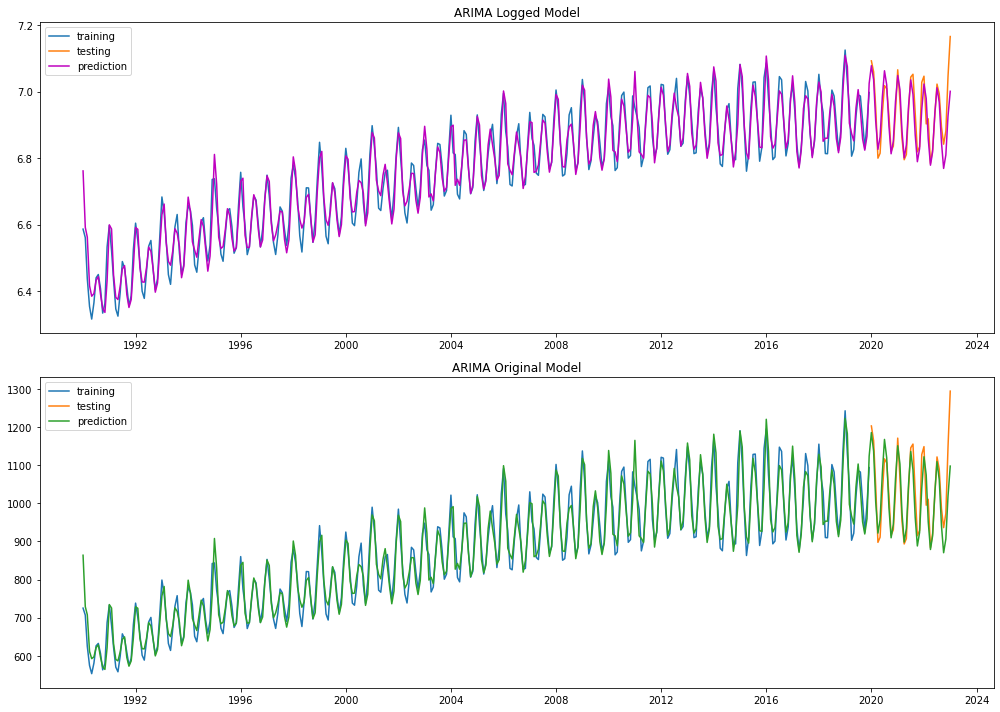

In [167]:
log_ec_model = ARIMA(logec_train_data, order=(3,0,3)).fit()
pred = log_ec_model.get_prediction(start='1990-1-1', end='2023-1-1').predicted_mean
oripred = np.exp(pred)

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14, 10))  # 2 rows, 1 column

# Plot ARIMA Logged Model
ax1.plot(logec_train_data, label='training')
ax1.plot(logec_test_data, label='testing')
ax1.plot(pred, label='prediction', color='m')
ax1.legend()
ax1.set_title('ARIMA Logged Model')

# Plot ARIMA Original Model
ax2.plot(ec_train_data, label='training')
ax2.plot(ec_test_data, label='testing')
ax2.plot(oripred, label='prediction')
ax2.legend()
ax2.set_title('ARIMA Original Model')

# Adjusting the layout for better spacing between subplots
plt.tight_layout()

# Displaying the combined subplot
plt.show()

In [168]:
# Evaluation
logecari_mape_train = mean_absolute_percentage_error(ec_train_data, oripred[oripred.index<'2020-1'])
logecari_mape_test = mean_absolute_percentage_error(ec_test_data, oripred[oripred.index>='2020-1'])
print(f'Model Mean Absolute Percentage Error on training data is {logecari_mape_train*100:.2f}%')
print(f'Model Mean Absolute Percentage Error on testing data is {logecari_mape_test*100:.2f}%')

logecari_mse_train = mean_squared_error(ec_train_data, oripred[oripred.index<'2020-1'])
logecari_mse_test = mean_squared_error(ec_test_data, oripred[oripred.index>='2020-1'])
print(f'\nModel Mean Squared Error on training data is {logecari_mse_train:.2f}')
print(f'Model Mean Squared Percentage Error on testing data is {logecari_mse_test:.2f}')

logecari_mae_train = mean_absolute_error(ec_train_data, oripred[oripred.index<'2020-1'])
logecari_mae_test = mean_absolute_error(ec_test_data, oripred[oripred.index>='2020-1'])
print(f'\nModel Mean Absolute Error on training data is {logecari_mae_train:.5f}')
print(f'Model Mean Absolute Error on testing data is {logecari_mae_test:.5f}')

Model Mean Absolute Percentage Error on training data is 2.85%
Model Mean Absolute Percentage Error on testing data is 3.71%

Model Mean Squared Error on training data is 1078.95
Model Mean Squared Percentage Error on testing data is 2999.66

Model Mean Absolute Error on training data is 24.95419
Model Mean Absolute Error on testing data is 39.52632


# Logged Electricity Consumption SARIMA Optimization

In [55]:
log_ec_sarimax_order = []

# Loop over AR order
for p in range(4):
    for q in range(4):
        for P in range(3):
            for D in range(2):
                for Q in range(3):
                    try:
                        # Fit model       
                        results = SARIMAX(logec_train_data, order=(p, 0, q), seasonal_order=(P, D, Q, 12)).fit()        
                        
                        # Make predictions
                        predictions = results.get_prediction(start='1990-1-1', end='2020-1-1').predicted_mean
            
                        # Calculate MAPE
                        mape =  mean_absolute_percentage_error(logec_train_data, predictions[predictions.index<'2020-1'])* 100
                        
                        log_ec_sarimax_order.append((p, q, P, D, Q, results.aic, results.bic, mape))
                    
                    except:
                        log_ec_sarimax_order.append((p, q, P, D, Q, None, None, None))

# Make DataFrame of model order, AIC, BIC, RMSE, and MAPE
log_ec_sarimax = pd.DataFrame(log_ec_sarimax_order, columns=['p', 'q', 'P', 'D', 'Q', 'aic', 'bic','mape'])

In [56]:
log_ec_sarimax_aic = log_ec_sarimax.sort_values('aic').reset_index(drop=True)
log_ec_sarimax_bic = log_ec_sarimax.sort_values('bic').reset_index(drop=True)
log_ec_sarimax_mape = log_ec_sarimax.sort_values('mape').reset_index(drop=True)


result = pd.concat([log_ec_sarimax_aic, log_ec_sarimax_bic], axis=1, keys=['Sorted by AIC', 'Sorted by BIC'])
result

Sorted by AIC                                                    \
                p  q  P  D  Q          aic          bic        mape   
0               1  3  1  0  1 -1614.077005 -1586.874277    0.577020   
1               1  2  1  0  2 -1612.404268 -1585.201540    0.580319   
2               1  2  1  0  1 -1611.145124 -1587.828500    0.579974   
3               2  3  1  0  1 -1600.982675 -1569.893842    0.583166   
4               2  3  0  1  1 -1596.995255 -1570.029837    3.603885   
..            ... .. .. .. ..          ...          ...         ...   
283             0  0  0  0  2  1541.161734  1552.820046   31.023265   
284             0  1  0  0  0  1910.755452  1918.527660   50.498655   
285             0  0  0  0  1  1954.971492  1962.743700   53.958351   
286             0  0  0  0  0  2399.528320  2403.414424  100.000000   
287             3  1  1  0  1          NaN          NaN         NaN   

    Sorted by BIC                                                    
                p  q  P  D  Q          aic          bic        mape  
0               1  2  1  0  1 -1611.145124 -1587.828500    0.579974  
1               1  3  1  0  1 -1614.077005 -1586.874277    0.577020  
2               1  2  1  0  2 -1612.404268 -1585.201540    0.580319  
3               1  2  0  1  1 -1593.930312 -1574.669299    3.606561  
4               2  2  0  1  1 -1596.035212 -1572.921997    3.604504  
..            ... .. .. .. ..          ...          ...         ...  
283             0  0  0  0  2  1541.161734  1552.820046   31.023265  
284             0  1  0  0  0  1910.755452  1918.527660   50.498655  
285             0  0  0  0  1  1954.971492  1962.743700   53.958351  
286             0  0  0  0  0  2399.528320  2403.414424  100.000000  
287             3  1  1  0  1          NaN          NaN         NaN  

[288 rows x 16 columns]

In [57]:
print("Sorted by MAPE:")
log_ec_sarimax_mape

Sorted by MAPE:


,p,q,P,D,Q,aic,bic,mape
0,1,3,2,0,2,-1570.677913,-1535.702977,0.574479
1,1,3,1,0,1,-1614.077005,-1586.874277,0.577020
2,1,2,2,0,2,-1582.820657,-1551.731825,0.577393
3,1,2,1,0,1,-1611.145124,-1587.828500,0.579974
4,1,2,1,0,2,-1612.404268,-1585.201540,0.580319
...,...,...,...,...,...,...,...,...
283,0,0,0,0,2,1541.161734,1552.820046,31.023265
284,0,1,0,0,0,1910.755452,1918.527660,50.498655
285,0,0,0,0,1,1954.971492,1962.743700,53.958351
286,0,0,0,0,0,2399.528320,2403.414424,100.000000


I decided to use the order=(1,0,3) and seasonal order=(2,0,2,12) as it has the best general fit and accuracy on the model

In [161]:
log_ec_sarimodel = SARIMAX(logec_train_data, order=(1,0,3),seasonal_order=(2,0,2,12)).fit()
pred = log_ec_sarimodel.get_prediction(start='1990-1-1', end='2023-1-1').predicted_mean
oripred = np.exp(pred)
print(log_ec_sarimodel.summary())

                                        SARIMAX Results                                        
Dep. Variable:           Electricity Consumption (MWh)   No. Observations:                  360
Model:             SARIMAX(1, 0, 3)x(2, 0, [1, 2], 12)   Log Likelihood                 794.339
Date:                                 Fri, 11 Aug 2023   AIC                          -1570.678
Time:                                         20:30:58   BIC                          -1535.703
Sample:                                     01-01-1990   HQIC                         -1556.771
                                          - 12-01-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9924      0.004    250.194      0.000       0.985       1

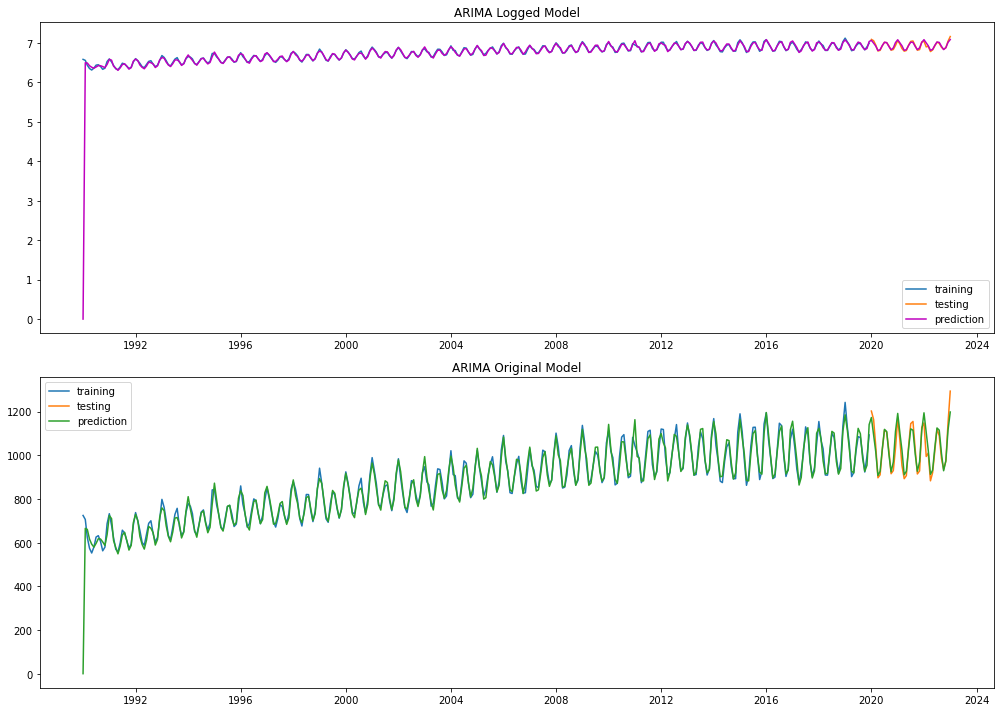

In [162]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14, 10))  

# Plot ARIMA Logged Model
ax1.plot(logec_train_data, label='training')
ax1.plot(logec_test_data, label='testing')
ax1.plot(pred, label='prediction', color='m')
ax1.legend()
ax1.set_title('ARIMA Logged Model')

# Plot ARIMA Original Model
ax2.plot(ec_train_data, label='training')
ax2.plot(ec_test_data, label='testing')
ax2.plot(oripred, label='prediction')
ax2.legend()
ax2.set_title('ARIMA Original Model')

# Adjusting the layout for better spacing between subplots
plt.tight_layout()

# Displaying the combined subplot
plt.show()

In [163]:
# Evaluation
logecsari_mape_train = mean_absolute_percentage_error(ec_train_data, oripred[oripred.index<'2020-1'])
logecsari_mape_test = mean_absolute_percentage_error(ec_test_data, oripred[oripred.index>='2020-1'])
print(f'Model Mean Absolute Percentage Error on training data is {logecsari_mape_train*100:.2f}%')
print(f'Model Mean Absolute Percentage Error on testing data is {logecsari_mape_test*100:.2f}%')

logecsari_mse_train = mean_squared_error(ec_train_data, oripred[oripred.index<'2020-1'])
logecsari_mse_test = mean_squared_error(ec_test_data, oripred[oripred.index>='2020-1'])
print(f'\nModel Mean Squared Error on training data is {logecsari_mse_train:.2f}')
print(f'Model Mean Squared Percentage Error on testing data is {logecsari_mse_test:.2f}')

logecsari_mae_train = mean_absolute_error(ec_train_data, oripred[oripred.index<'2020-1'])
logecsari_mae_test = mean_absolute_error(ec_test_data, oripred[oripred.index>='2020-1'])
print(f'\nModel Mean Absolute Error on training data is {logecsari_mae_train:.5f}')
print(f'Model Mean Absolute Error on testing data is {logecsari_mae_test:.5f}')

Model Mean Absolute Percentage Error on training data is 2.28%
Model Mean Absolute Percentage Error on testing data is 2.69%

Model Mean Squared Error on training data is 1977.34
Model Mean Squared Percentage Error on testing data is 1441.14

Model Mean Absolute Error on training data is 19.64495
Model Mean Absolute Error on testing data is 28.14642


# Logged Electricity Consumption ARIMA VS SARIMA

In [229]:
logec_comparision_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA'],
    'MAPE':[ logecari_mape_test*100, logecsari_mape_test*100],
    'MAE': [logecari_mae_test, logecsari_mae_test],
    'MSE': [logecari_mse_test, logecsari_mse_test]
})
logec_comparision_df

,Model,MAPE,MAE,MSE
0,ARIMA,3.709835,39.526325,2999.661893
1,SARIMA,2.691579,28.146418,1441.144376


From this table, I can see that the SARIMA model outperforms the ARIMA on the logged electricity consumption data which is expected since electricity consumption data have seasonality

# Logged Electricity Consumption VS Electricity Consumption

In [242]:
logged_comparison_data = {
    'Data': ['Logged'],
    'ARIMA_MAPE': [logecari_mape_test*100],
    'ARIMA_MAE': [logecari_mae_test],
    'ARIMA_MSE': [logecari_mse_test],
    'SARIMA_MAPE': [logecsari_mape_test*100],
    'SARIMA_MAE': [logecsari_mae_test],
    'SARIMA_MSE': [logecsari_mse_test]
}

original_comparison_data = {
    'Data': ['Original'],
    'ARIMA_MAPE': [ecari_mape_test*100],
    'ARIMA_MAE': [ecari_mae_test],
    'ARIMA_MSE': [ecari_mse_test],
    'SARIMA_MAPE': [ecsari_mape_test*100],
    'SARIMA_MAE': [ecsari_mae_test],
    'SARIMA_MSE': [ecsari_mse_test]
}

logged_comparison_df = pd.DataFrame(logged_comparison_data)
original_comparison_df = pd.DataFrame(original_comparison_data)

comparison_df = pd.concat([logged_comparison_df, original_comparison_df], ignore_index=True)

comparison_df

,Data,ARIMA_MAPE,ARIMA_MAE,ARIMA_MSE,SARIMA_MAPE,SARIMA_MAE,SARIMA_MSE
0,Logged,3.709835,39.526325,2999.661893,2.691579,28.146418,1441.144376
1,Original,4.449690,45.438150,3000.834460,2.371245,25.052907,1194.073956


Surprisingly, the original data still beats the logged data after the SARIMA model fitted the data, but the logged data beats the original when using the ARIMA model. This is interesting and could be because logging the data removes the seasonality of the data.

# Water Consumption

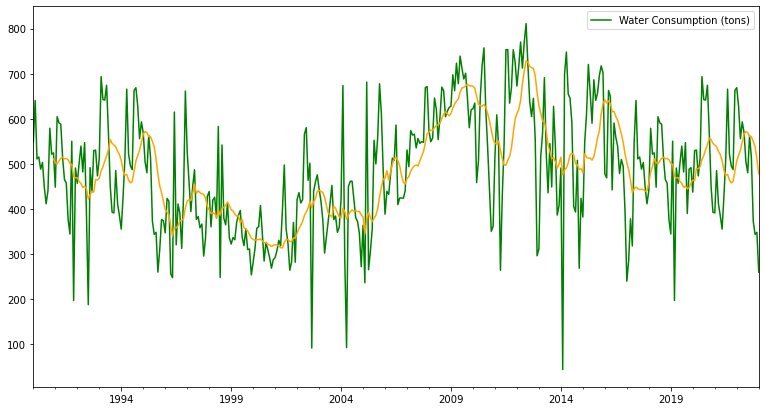

In [60]:
data['Water Consumption (tons)'].plot(figsize=(13,7), legend=True, color='g')
data['Water Consumption (tons)'].rolling(window=12).mean().plot(color='orange')
plt.show()

# Water Consumption Stationary Check

In [61]:
adf = adfuller(data['Water Consumption (tons)'])
print(f"P-value:{adf[1]}")
if adf[1] < 0.05:
    print("Since P value is small, we reject the null hypothesis. The time series is stationary")
else:
    print("Since P value is larger than 0.05, we cannot reject the null hypothesis. The time series is non-stationary")

P-value:8.984549388336973e-05
Since P value is small, we reject the null hypothesis. The time series is stationary


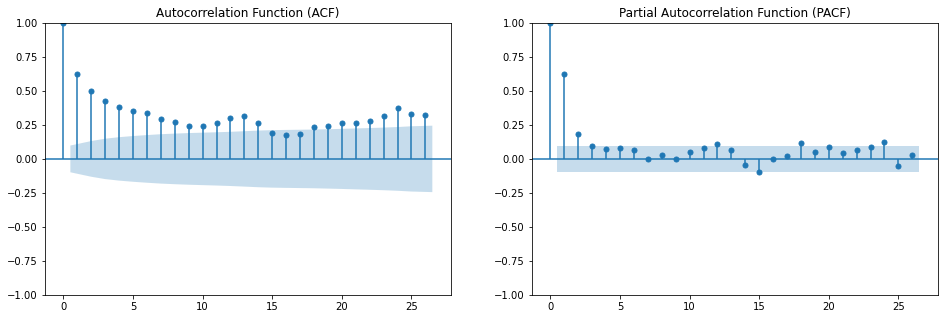

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot the ACF
plot_acf(data['Water Consumption (tons)'], ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot the PACF
plot_pacf(data['Water Consumption (tons)'], ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

# Display the plot
plt.show()

# Water Consumption Train-test split

In [63]:
# define training dataset
water_consumption = data['Water Consumption (tons)']
wc_train_data = water_consumption[water_consumption.index<'2020-1']
wc_test_data = water_consumption[water_consumption.index>='2020-1']

# Water Consumption Holt Winters

In [64]:
alpha_values = np.linspace(0.01, 0.99, num=20)
best_alpha = None
best_rmse = float('inf')

for alpha in alpha_values:
    model = ExponentialSmoothing(wc_train_data, trend='add', damped_trend=True, freq='MS')
    model_fit = model.fit(smoothing_level=alpha)
    
    # Make predictions on validation set
    pred = model_fit.forecast(steps=len(wc_test_data))
    
    # Calculate RMSE (you can choose a different metric)
    rmse = np.sqrt(mean_squared_error(wc_test_data, pred))
    
    # Update best alpha if this model has lower RMSE
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha

print("Best Alpha:", best_alpha)
print("Best RMSE:", best_rmse)

Best Alpha: 0.01
Best RMSE: 108.85072143711673


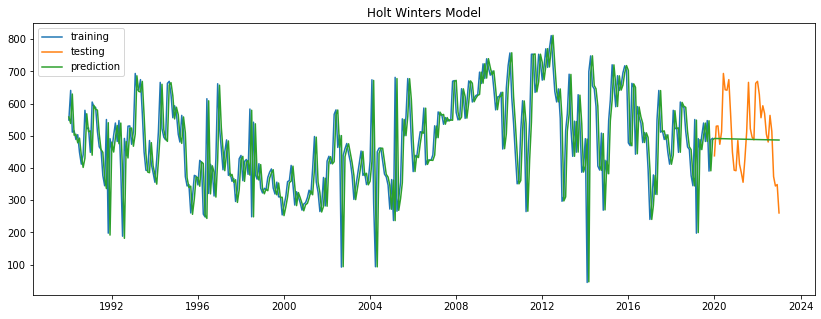

In [219]:
model = model = ExponentialSmoothing(wc_train_data, trend='add', damped_trend=True, freq='MS').fit(smoothing_level=alpha)
pred1 = model.predict(start='1990-1-1', end='2023-1-1')
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(wc_train_data, label='training')
ax.plot(wc_test_data, label='testing')
ax.plot(pred1, label='prediction')
plt.legend()
plt.title('Holt Winters Model')
plt.show()

# Water Consumption Holt Winters Results

In [66]:
# Evaluation
mape_train = mean_absolute_percentage_error(wc_train_data, pred1[pred1.index<'2020-1'])
mape_test = mean_absolute_percentage_error(wc_test_data, pred1[pred1.index>='2020-1'])
print(f'Model Mean Absolute Percentage Error on training data is {mape_train*100:.2f}%')
print(f'Model Mean Absolute Percentage Error on testing data is {mape_test*100:.2f}%')

mse_train = mean_squared_error(wc_train_data, pred1[pred1.index<'2020-1'])
mse_test = mean_squared_error(wc_test_data, pred1[pred1.index>='2020-1'])
print(f'\nModel Mean Squared Error on training data is {mse_train:.2f}')
print(f'Model Mean Squared Percentage Error on testing data is {mse_test:.2f}')

mae_train = mean_absolute_error(wc_train_data, pred1[pred1.index<'2020-1'])
mae_test = mean_absolute_error(wc_test_data, pred1[pred1.index>='2020-1'])
print(f'\nModel Mean Absolute Error on training data is {mae_train:.2f}')
print(f'Model Mean Absolute Error on testing data is {mae_test:.2f}')

Model Mean Absolute Percentage Error on training data is 22.10%
Model Mean Absolute Percentage Error on testing data is 18.68%

Model Mean Squared Error on training data is 13957.18
Model Mean Squared Percentage Error on testing data is 11937.64

Model Mean Absolute Error on training data is 79.04
Model Mean Absolute Error on testing data is 89.04


__Mean Absolute Percentage Error__

This means that for my model with a MAPE of 22.10% for the training data, my predictions have deviated 22.10% on average away from the true values and for my model with a MAPE of 18.68% for the test data, my predictions have deviated 18.68% on average away from the true values, this is significantly worse than the fit for all the other time series thus I conclude that my model have a pretty bad fit.

__Mean Squared Error__ 

My model's train Mean Squared Error not very good with a MSE of 13957.18 and my model's test Mean Squared Error is good with a MSE of 11937.64 even after considering the scale of the water consumption data.

__Mean Absolute Error__

My model's train Mean Absolute Error is quite good with a MAE of 79.04 and my model's test Mean Absolute Error is quite good with a MAE of 89.04 considering the scale of the water consumption data.

# Water Consumption ARIMA Optimization

In [69]:
# ARIMA model
wc_arima_order =[]
# Loop over AR order
for p in range(4):
    # Loop over MA order
    for q in range(4):
        try:
            # Fit model       
            results = ARIMA(wc_train_data, order=(p,0,q)).fit()       
            
            # Make predictions
            predictions = results.get_prediction(start='1990-1-1', end='2020-1-1').predicted_mean
            
            # Calculate MAPE
            mape =  mean_absolute_percentage_error(wc_train_data, predictions[predictions.index<'2020-1'])* 100
            
            wc_arima_order.append((p, q, results.aic, results.bic, mape))
                                  
        except:
                                  
            wc_arima_order.append((p, q, None, None, None))

# Make DataFrame of model order and AIC/BIC 
wc_arima = pd.DataFrame(wc_arima_order, columns=['p','q','aic','bic','mape'])

In [70]:
wc_arima_aic = wc_arima.sort_values('aic').reset_index(drop=True)
wc_arima_bic = wc_arima.sort_values('bic').reset_index(drop=True)
wc_arima_mape = wc_arima.sort_values('mape').reset_index(drop=True)

result = pd.concat([wc_arima_aic, wc_arima_bic, wc_arima_mape], axis=1, keys=['Sorted by AIC', 'Sorted by BIC', 'Sorted by AMPE'])
result

Sorted by AIC                                         Sorted by BIC     \
               p  q          aic          bic       mape             p  q   
0              2  2  4364.755158  4388.071782  21.510123             2  1   
1              3  1  4364.867041  4388.183666  21.504266             1  1   
2              2  1  4364.906235  4384.336755  21.526740             1  2   
3              2  3  4366.751471  4393.954200  21.512599             2  2   
4              3  2  4367.032149  4394.234877  21.553561             3  1   
5              1  3  4367.325556  4390.642180  21.509279             1  3   
6              3  3  4367.539060  4398.627892  21.553026             2  0   
7              1  2  4368.078065  4387.508585  21.596985             2  3   
8              1  1  4370.202889  4385.747306  21.825467             3  0   
9              3  0  4374.781125  4394.211645  21.883260             3  2   
10             2  0  4376.655512  4392.199928  21.975702             3  3   
11             1  0  4389.030200  4400.688512  22.328397             1  0   
12             0  3  4403.262800  4422.693320  23.258376             0  3   
13             0  2  4419.537866  4435.082282  24.131712             0  2   
14             0  1  4455.546693  4467.205005  25.892711             0  1   
15             0  0  4562.226374  4569.998582  30.182984             0  0   

                                        Sorted by AMPE                  \
            aic          bic       mape              p  q          aic   
0   4364.906235  4384.336755  21.526740              3  1  4364.867041   
1   4370.202889  4385.747306  21.825467              1  3  4367.325556   
2   4368.078065  4387.508585  21.596985              2  2  4364.755158   
3   4364.755158  4388.071782  21.510123              2  3  4366.751471   
4   4364.867041  4388.183666  21.504266              2  1  4364.906235   
5   4367.325556  4390.642180  21.509279              3  3  4367.539060   
6   4376.655512  4392.199928  21.975702              3  2  4367.032149   
7   4366.751471  4393.954200  21.512599              1  2  4368.078065   
8   4374.781125  4394.211645  21.883260              1  1  4370.202889   
9   4367.032149  4394.234877  21.553561              3  0  4374.781125   
10  4367.539060  4398.627892  21.553026              2  0  4376.655512   
11  4389.030200  4400.688512  22.328397              1  0  4389.030200   
12  4403.262800  4422.693320  23.258376              0  3  4403.262800   
13  4419.537866  4435.082282  24.131712              0  2  4419.537866   
14  4455.546693  4467.205005  25.892711              0  1  4455.546693   
15  4562.226374  4569.998582  30.182984              0  0  4562.226374   

                            
            bic       mape  
0   4388.183666  21.504266  
1   4390.642180  21.509279  
2   4388.071782  21.510123  
3   4393.954200  21.512599  
4   4384.336755  21.526740  
5   4398.627892  21.553026  
6   4394.234877  21.553561  
7   4387.508585  21.596985  
8   4385.747306  21.825467  
9   4394.211645  21.883260  
10  4392.199928  21.975702  
11  4400.688512  22.328397  
12  4422.693320  23.258376  
13  4435.082282  24.131712  
14  4467.205005  25.892711  
15  4569.998582  30.182984

# Water Consumption ARIMA

I decided to use order=(2,0,2) as it generally had the best results of the 3 orders

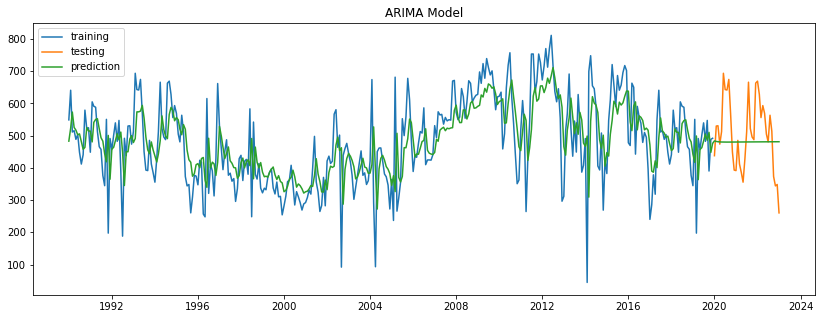

In [198]:
model = ARIMA(wc_train_data, order=(2,0,2)).fit()
pred = model.get_prediction(start='1990-1-1', end='2023-1-1').predicted_mean
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(wc_train_data, label='training')
ax.plot(wc_test_data, label='testing')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('ARIMA Model')
plt.show()

# Water Consumption ARIMA Results

In [199]:
# Evaluation
wcarima_mape_train = mean_absolute_percentage_error(wc_train_data, pred[pred.index<'2020-1'])
wcarima_mape_test = mean_absolute_percentage_error(wc_test_data, pred[pred.index>='2020-1'])
print(f'Model Mean Absolute Percentage Error on training data is {wcarima_mape_train*100:.2f}%')
print(f'Model Mean Absolute Percentage Error on testing data is {wcarima_mape_test*100:.2f}%')

wcarima_mse_train = mean_squared_error(wc_train_data, pred[pred.index<'2020-1'])
wcarima_mse_test = mean_squared_error(wc_test_data, pred[pred.index>='2020-1'])
print(f'\nModel Mean Squared Error on training data is {wcarima_mse_train:.2f}')
print(f'Model Mean Squared Percentage Error on testing data is {wcarima_mse_test:.2f}')

wcarima_mae_train = mean_absolute_error(wc_train_data, pred[pred.index<'2020-1'])
wcarima_mae_test = mean_absolute_error(wc_test_data, pred[pred.index>='2020-1'])
print(f'\nModel Mean Absolute Error on training data is {wcarima_mae_train:.2f}')
print(f'Model Mean Absolute Error on testing data is {wcarima_mae_test:.2f}')

Model Mean Absolute Percentage Error on training data is 21.51%
Model Mean Absolute Percentage Error on testing data is 18.77%

Model Mean Squared Error on training data is 10422.76
Model Mean Squared Percentage Error on testing data is 12410.01

Model Mean Absolute Error on training data is 74.58
Model Mean Absolute Error on testing data is 90.99


__Mean Absolute Percentage Error__

This means that for my model with a MAPE of 21.51% for the training data, my predictions have deviated 21.51% on average away from the true values and for my model with a MAPE of 18.77% for the test data, my predictions have deviated 18.77% on average away from the true values, this is significantly worse than the fit for all the other time series thus I conclude that my model have a pretty bad fit.

__Mean Squared Error__ 

My model's train Mean Squared Error not very good with a MSE of 10422.76 and my model's test Mean Squared Error with a MSE of 12410.01 considering the fact that water consumption has a larger scale.

__Mean Absolute Error__

My model's train Mean Absolute Error is quite good with a MAE of 74.58 and my model's test Mean Absolute Error with a MAE of 90.99

# Water Consumption ARIMA Diagnostic Plot

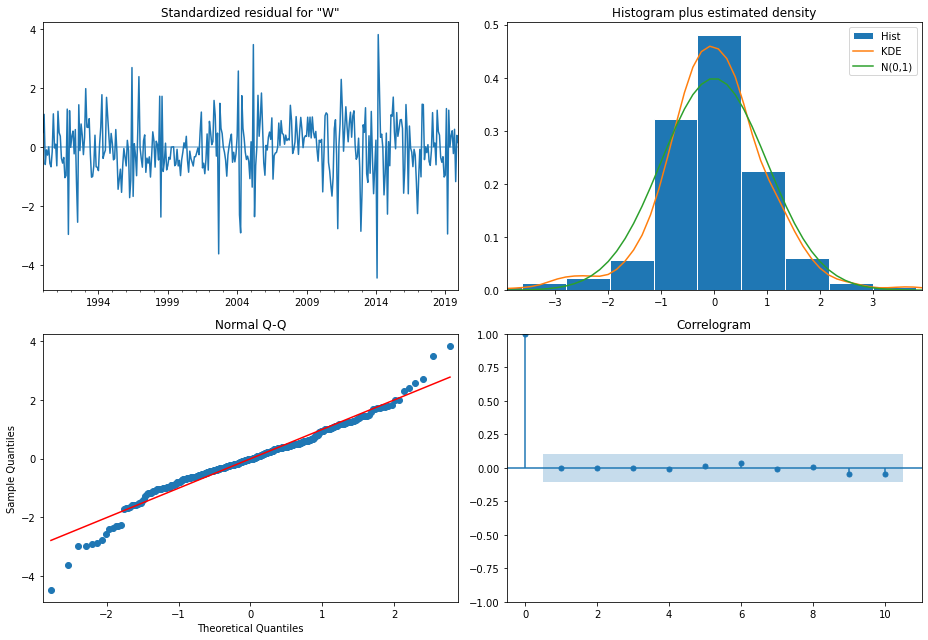

In [73]:
figure = model.plot_diagnostics()
figure.set_size_inches((13, 9))
figure.tight_layout()
plt.show()

# Water Consumption SARIMA Optimization

I decied to set seasons to 12 since my background research shows that water consumption have a yearly trend

In [74]:
wc_sarimax_order =[]
# Loop over AR order
for p in range(4):
    for q in range(4):
        for P in range(3):
            for D in range(2):
                for Q in range(3):
                    try:
                        # Fit model       
                        results = SARIMAX(wc_train_data, order=(p,0,q),seasonal_order=(P,D,Q,12)).fit()
                        
                        # Make predictions
                        predictions = results.get_prediction(start='1990-1-1', end='2020-1-1').predicted_mean
            
                        # Calculate MAPE
                        mape =  mean_absolute_percentage_error(wc_train_data, predictions[predictions.index<'2020-1'])* 100
                    
                        wc_sarimax_order.append((p, q, P, D, Q, results.aic, results.bic, mape))
                    
                    except:
                        wc_sarimax_order.append((p, q, P, D, Q, None, None, None))

                        
# Make DataFrame of model order and AIC/BIC 
wc_sarimax = pd.DataFrame(wc_sarimax_order, columns=['p','q','P','D','Q','aic', 'bic','mape'])

In [94]:
wc_sarimax_aic = wc_sarimax.sort_values('aic').reset_index(drop=True)
wc_sarimax_bic = wc_sarimax.sort_values('bic').reset_index(drop=True)
wc_sarimax_mape = wc_sarimax.sort_values('mape').reset_index(drop=True)

result = pd.concat([wc_sarimax_aic, wc_sarimax_bic], axis =1 ,keys=['Sorted by AIC', 'Sorted by BIC'])
result

Sorted by AIC                                                    \
                p  q  P  D  Q          aic          bic        mape   
0               2  1  2  1  1  4250.557987  4277.523405   25.049616   
1               2  2  2  1  1  4251.953908  4282.771527   25.201907   
2               2  1  0  1  1  4251.976928  4271.237941   25.189507   
3               1  3  2  1  1  4252.307197  4283.124817   25.044965   
4               1  2  0  1  1  4252.369898  4271.630911   25.202907   
..            ... .. .. .. ..          ...          ...         ...   
283             0  0  0  0  2  5023.853398  5035.511710   44.287066   
284             0  1  0  0  0  5142.995321  5150.767530   58.263577   
285             0  0  0  0  1  5219.304162  5227.076370   59.111230   
286             0  0  0  0  0  5500.272077  5504.158181  100.000000   
287             0  3  2  0  2          NaN          NaN         NaN   

    Sorted by BIC                                                    
                p  q  P  D  Q          aic          bic        mape  
0               1  1  0  1  1  4255.316155  4270.724965   25.348563  
1               2  1  0  1  1  4251.976928  4271.237941   25.189507  
2               1  2  0  1  1  4252.369898  4271.630911   25.202907  
3               1  1  2  1  1  4252.897325  4276.010540   25.247503  
4               2  2  0  1  1  4253.236759  4276.349974   25.274324  
..            ... .. .. .. ..          ...          ...         ...  
283             0  0  0  0  2  5023.853398  5035.511710   44.287066  
284             0  1  0  0  0  5142.995321  5150.767530   58.263577  
285             0  0  0  0  1  5219.304162  5227.076370   59.111230  
286             0  0  0  0  0  5500.272077  5504.158181  100.000000  
287             0  3  2  0  2          NaN          NaN         NaN  

[288 rows x 16 columns]

In [76]:
print("Sorted by MAPE:")
wc_sarimax_mape

Sorted by MAPE:


,p,q,P,D,Q,aic,bic,mape
0,2,1,2,0,1,4368.752194,4395.954922,21.068287
1,2,3,2,0,1,4372.243632,4407.218568,21.088262
2,2,2,1,0,2,4369.499231,4400.588063,21.104920
3,2,2,2,0,1,4368.702907,4399.791739,21.148220
4,2,3,1,0,2,4374.100514,4409.075450,21.151804
...,...,...,...,...,...,...,...,...
283,0,3,0,0,1,5011.256608,5030.687128,47.340484
284,0,1,0,0,0,5142.995321,5150.767530,58.263577
285,0,0,0,0,1,5219.304162,5227.076370,59.111230
286,0,0,0,0,0,5500.272077,5504.158181,100.000000


# Water Consumption SARIMA

I decided to use order=(2,0,1,) seasonal order=(2,0,1,12) it has the best accuracy among the 3 orders. However, all 3 orders resulted in the test accuracy being more accurate than the train which could be due to water not have seasonality thus sarima overfits the model.

In [234]:
model = SARIMAX(wc_train_data, order=(1,0,1),seasonal_order=(0,1,1,12)).fit()
wc_sari_pred = model.get_prediction(start='1990-1-1', end='2023-1-1').predicted_mean
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:           Water Consumption (tons)   No. Observations:                  360
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -2123.658
Date:                            Fri, 11 Aug 2023   AIC                           4255.316
Time:                                    23:25:20   BIC                           4270.725
Sample:                                01-01-1990   HQIC                          4261.451
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8842      0.043     20.799      0.000       0.801       0.967
ma.L1         -0.5201      0.064   

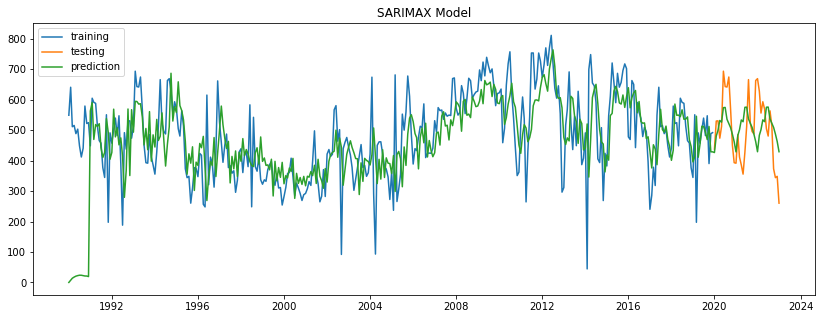

In [235]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(wc_train_data, label='training')
ax.plot(wc_test_data, label='testing')
ax.plot(wc_sari_pred, label='prediction')
plt.legend()
plt.title('SARIMAX Model')
plt.show()

In [236]:
# Evaluation
wcsari_mape_train = mean_absolute_percentage_error(wc_train_data, wc_sari_pred[wc_sari_pred.index<'2020-1'])
wcsari_mape_test = mean_absolute_percentage_error(wc_test_data, wc_sari_pred[wc_sari_pred.index>='2020-1'])
print(f'Model Mean Absolute Percentage Error on training data is {wcsari_mape_train*100:.2f}%')
print(f'Model Mean Absolute Percentage Error on testing data is {wcsari_mape_test*100:.2f}%')

wcsari_mse_train = mean_squared_error(wc_train_data, wc_sari_pred[wc_sari_pred.index<'2020-1'])
wcsari_mse_test = mean_squared_error(wc_test_data, wc_sari_pred[wc_sari_pred.index>='2020-1'])
print(f'\nModel Mean Squared Error on training data is {wcsari_mse_train:.2f}')
print(f'Model Mean Squared Percentage Error on testing data is {wcsari_mse_test:.2f}')

wcsari_mae_train = mean_absolute_error(wc_train_data, wc_sari_pred[wc_sari_pred.index<'2020-1'])
wcsari_mae_test = mean_absolute_error(wc_test_data, wc_sari_pred[wc_sari_pred.index>='2020-1'])
print(f'\nModel Mean Absolute Error on training data is {wcsari_mae_train:.2f}')
print(f'Model Mean Absolute Error on testing data is {wcsari_mae_test:.2f}')

Model Mean Absolute Percentage Error on training data is 25.35%
Model Mean Absolute Percentage Error on testing data is 17.73%

Model Mean Squared Error on training data is 19460.69
Model Mean Squared Percentage Error on testing data is 10702.58

Model Mean Absolute Error on training data is 93.81
Model Mean Absolute Error on testing data is 83.34


__Mean Absolute Percentage Error__

This means that for my model with a MAPE of 25.35% for the training data, my predictions have deviated 25.35% on average away from the true values and for my model with a MAPE of 17.73% for the test data, my predictions have deviated 17.73% on average away from the true values, this is moderately bad even after considering the large scale of water consumption.

__Mean Squared Error__

My model's train Mean Squared Error not very good with a MSE of 19460.69 and my model's test Mean Squared Error with a MSE of 10702.58 even after considering the fact that water consumption has a larger scale.

__Mean Absolute Error__

My model's train Mean Absolute Error is quite good with a MAE of 93.81 and my model's test Mean Absolute Error with a MAE of 83.34

# Water Consumption SARIMA Diagnostic Plot

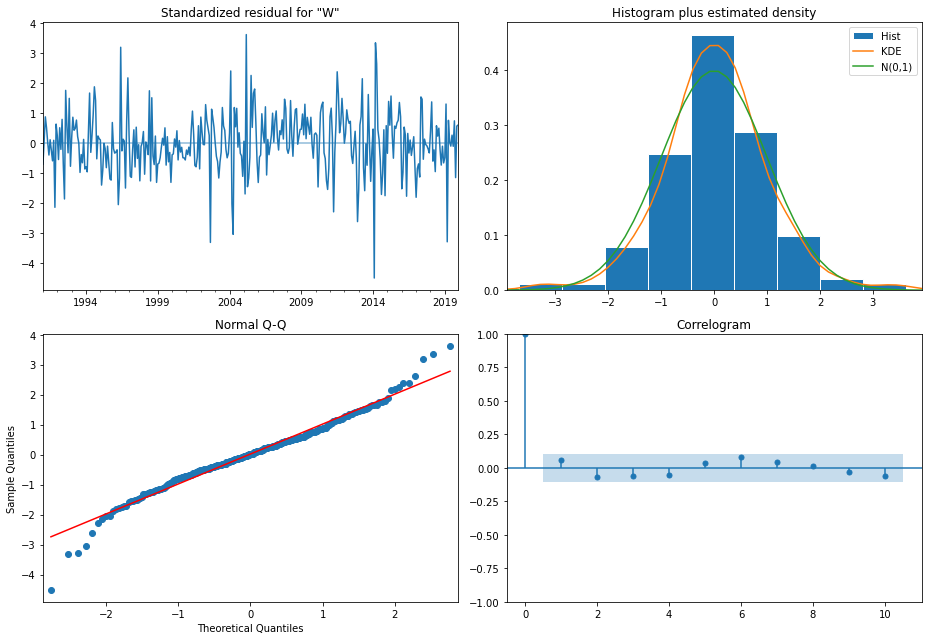

In [237]:
figure = model.plot_diagnostics()
figure.set_size_inches((13, 9))
figure.tight_layout()
plt.show()

# Water Consumption ARIMA VS SARIMA

In [206]:
wc_comparision_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA'],
    'MAPE':[ wcarima_mape_test*100, wcsari_mape_test*100],
    'MAE': [wcarima_mae_test, wcsari_mae_test],
    'MSE': [wcarima_mse_test, wcsari_mse_test]
})
wc_comparision_df

,Model,MAPE,MAE,MSE
0,ARIMA,18.767155,90.987014,12410.006484
1,SARIMA,17.726285,83.336501,10702.575256


From my code it seems like my sarima model is better than my arima which is surprising because the acf plot did not show any seasonality. From my understanding, it seems like my sarima model might have picked up some underlying seasonality which could result in this result.

# Final Plot

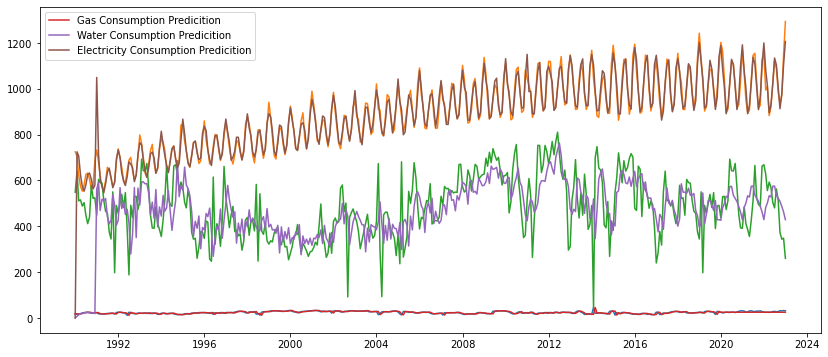

In [227]:
plt.figure(figsize=(14,6))

plt.plot(gas_consumption)
plt.plot(electricity_consumption)
plt.plot(water_consumption)

plt.plot(gc_pred_hw, label='Gas Consumption Predicition')
plt.plot(wc_sari_pred, label='Water Consumption Predicition')
plt.plot(ecsari_pred, label='Electricity Consumption Predicition')

plt.legend()
plt.show()